=== STGCN version 1 - Only original wastewater features ===
✓ PROJ_DATA set to: /opt/homebrew/share/proj
Using device: cpu

1. Loading data...
Data shape: (2398, 20)
Time range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

2. Building graph structure...
  Building adjacency graph...
    Found 124 adjacency relationships
    Average number of adjacent regions per region: 4.59
  Building distance graph (k=5)...
    Each region connects to 5 nearest neighbors
Adjacency graph shape: (27, 27)
Distance graph shape: (27, 27)

3. Building flexible time window data set...
Ti

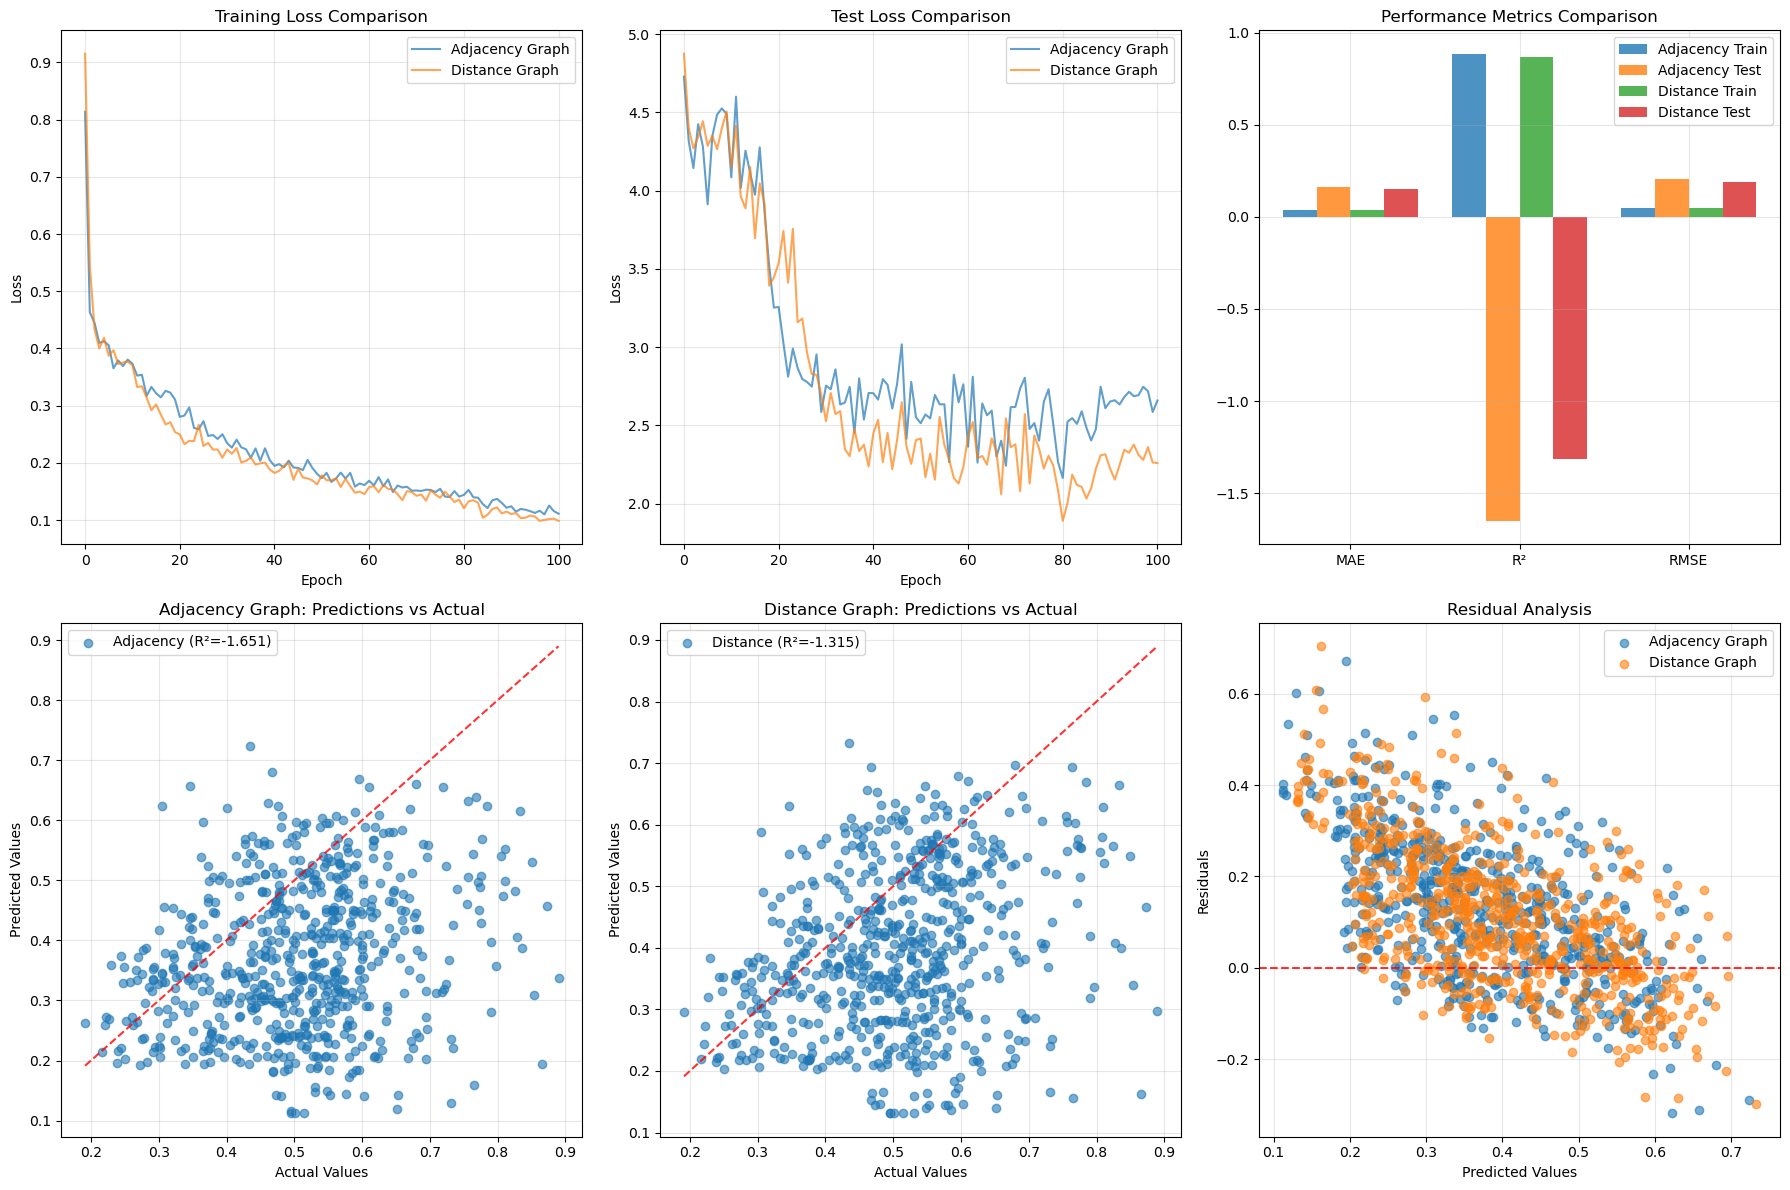


STGCN model training completed (flexible time window + only original wastewater features)
Feature composition:
  - Time series features: 15 features/day × 7 days = 105 time series features
    * Original wastewater features: 15 features
  - Total features: 105 features

Core strategy:
  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window
  ✓ Strict 7-day time window, do not use data from the prediction day
  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic
  ✓ Only use original wastewater features, keep feature purity
  ✓ Support adjacency graph and distance graph two graph structures

10. Save model results and prediction data...
Adjacency graph model training epochs: 101
Distance graph model training epochs: 101
Save the first 101 epochs of training history
STGCN original features model results saved:
  - Performance metrics: ../results/stgcn_version_1_original_features_metrics_summary.csv
  - Adjacency graph predictions: .

In [1]:
##### STGCN version 1 - Only original wastewater features

print("=== STGCN version 1 - Only original wastewater features ===")

# First set up PROJ data directory
import os
import warnings
warnings.filterwarnings('ignore')

# Set up PROJ data directory environment variable
try:
    import pyproj
    proj_data_dir = pyproj.datadir.get_data_dir()
    os.environ['PROJ_DATA'] = proj_data_dir
    print(f"✓ PROJ_DATA set to: {proj_data_dir}")
except Exception as e:
    print(f"Warning: Could not set PROJ_DATA: {e}")
    # Try some common paths
    possible_paths = [
        '/opt/anaconda3/share/proj',
        '/usr/share/proj', 
        '/usr/local/share/proj',
        '/opt/homebrew/share/proj'
    ]
    for path in possible_paths:
        if os.path.exists(path):
            os.environ['PROJ_DATA'] = path
            print(f"✓ Manually set PROJ_DATA to: {path}")
            break

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import geopandas as gpd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Data loading
print("\n1. Loading data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Time range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()

print(f"Number of CIS regions: {len(cis_regions)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

# 2. Graph structure building
print("\n2. Building graph structure...")

def load_cis_boundaries():
    """Load CIS boundary data"""
    shp_path = '../data/raw/Boundaries data/Covid_Infection_Survey_Dec_2020_UK_BUC_-6314666778913437735/CIS_DEC_2020_UK_BUC.shp'
    cis_geo = gpd.read_file(shp_path)
    return cis_geo

def create_adjacency_graph(cis_codes, cis_geo):
    """Create adjacency graph based on geographic adjacency"""
    cis_to_idx = {cis: idx for idx, cis in enumerate(cis_codes)}
    idx_to_cis = {idx: cis for cis, idx in cis_to_idx.items()}
    
    n = len(cis_codes)
    adj_matrix = np.zeros((n, n))
    
    adjacency_count = 0
    for i, cis1 in enumerate(cis_codes):
        if cis1 in cis_geo['CIS20CD'].values:
            geom1 = cis_geo[cis_geo['CIS20CD'] == cis1].geometry.iloc[0]
            
            for j, cis2 in enumerate(cis_codes):
                if i != j and cis2 in cis_geo['CIS20CD'].values:
                    geom2 = cis_geo[cis_geo['CIS20CD'] == cis2].geometry.iloc[0]
                    
                    if geom1.touches(geom2):
                        adj_matrix[i, j] = 1
                        adjacency_count += 1
    
    print(f"  Building adjacency graph...")
    print(f"    Found {adjacency_count} adjacency relationships")
    print(f"    Average number of adjacent regions per region: {adjacency_count / n:.2f}")
    
    return adj_matrix, cis_to_idx, idx_to_cis

def create_distance_graph(cis_codes, cis_geo, k_neighbors=5):
    """Create k-nearest neighbor graph based on distance"""
    n = len(cis_codes)
    centroids = []
    
    for cis in cis_codes:
        if cis in cis_geo['CIS20CD'].values:
            geom = cis_geo[cis_geo['CIS20CD'] == cis].geometry.iloc[0]
            centroid = geom.centroid
            centroids.append([centroid.x, centroid.y])
        else:
            centroids.append([0, 0])
    
    centroids = np.array(centroids)
    distances = cdist(centroids, centroids)
    
    adj_matrix = np.zeros((n, n))
    for i in range(n):
        nearest_indices = np.argsort(distances[i])[1:k_neighbors+1]
        adj_matrix[i, nearest_indices] = 1
        adj_matrix[nearest_indices, i] = 1
    
    print(f"  Building distance graph (k={k_neighbors})...")
    print(f"    Each region connects to {k_neighbors} nearest neighbors")
    
    return adj_matrix

# Load CIS boundaries and build graph
cis_geo = load_cis_boundaries()
cis_codes = sorted(list(cis_regions))
adjacency_adj, cis_to_idx, idx_to_cis = create_adjacency_graph(cis_codes, cis_geo)
distance_adj = create_distance_graph(cis_codes, cis_geo, k_neighbors=5)

print(f"Adjacency graph shape: {adjacency_adj.shape}")
print(f"Distance graph shape: {distance_adj.shape}")

# 3. Flexible time window data preparation (only original features)
print("\n3. Building flexible time window data set...")

def create_flexible_time_window_with_original_features(data, window_days=7):
    """
    Create flexible time window data set, containing:
    - Original features (15 features) in the past window_days days
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. The prediction day must start from the 8th day of the data
    2. Each prediction day needs to have a complete 7-day history window
    3. If there is data, use it, otherwise use 0 to fill
    4. Never use any data from the prediction day or future
    """
    
    sequences = []
    targets = []
    regions = []
    dates = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predict date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Group by CIS region
    for cis in cis_codes:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the region, to the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                sequence_features = []
                day_availability = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days before
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # With data: use real value
                        hist_row = cis_date_data[hist_date]
                        # Only use original features (15 features)
                        day_features = hist_row[original_features].values
                        day_availability.append(1)  # Mark with data
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0 to fill
                        day_features = np.zeros(len(original_features))  # 15 zeros
                        day_availability.append(0)  # Mark as no data
                    
                    sequence_features.append(day_features)
                    availability_stats['total_hist_days'] += 1
                
                sequence_features = np.array(sequence_features)  # shape: (window_days, 15)
                
                sequences.append(sequence_features)
                targets.append(pred_target)
                regions.append(cis)
                dates.append(current_date)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    sequences = np.array(sequences)  # shape: (n_samples, window_days, 15)
    targets = np.array(targets)
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in the data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average effective history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average samples per CIS region: {availability_stats['total_samples']/len(cis_codes):.1f}")
    
    return sequences, targets, regions, dates

# Create data set
sequences, targets, sample_regions, sample_dates = create_flexible_time_window_with_original_features(
    data, window_days=7
)

print(f"\n=== Data set shape ===")
print(f"  Sequence features: {sequences.shape}")  # (n_samples, 7, 15) - 15 features per day
print(f"  Target: {targets.shape}")
print(f"  Total samples: {len(targets)}")

# Feature description
print(f"\n=== Feature composition ===")
print(f"Time series features (per sample):")
print(f"  - 1 day before: 15 features")
print(f"  - 2 days before: 15 features")
print(f"  - 3 days before: 15 features")
print(f"  - 4 days before: 15 features")
print(f"  - 5 days before: 15 features")
print(f"  - 6 days before: 15 features")
print(f"  - 7 days before: 15 features")
print(f"  Total: 15 × 7 = 105 time series features")

print(f"\nTotal features: 105")

print(f"\n=== Strategy verification ===")
print(f"✓ Prediction day selection: Start from the {7+1}th day of the data, ensure a complete history window")
print(f"✓ History window: Strict 7-day time window (1-7 days before the prediction day)")
print(f"✓ Missing data handling: Use 0 to fill if there is no data in the history window")
print(f"✓ Time boundary: Never use data from the prediction day or future")
print(f"✓ Feature purity: Only use original wastewater features")

# Verify time logic
print(f"\n=== Time logic example ===")
if len(sample_dates) > 0:
    # Show time logic of the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {targets[i]:.4f}")
        print(f"  CIS region: {sample_regions[i]}")
        print()

# Verify no future data
print(f"=== Time safety verification ===")
sample_dates_array = np.array(sample_dates)
min_pred_date = sample_dates_array.min()
max_pred_date = sample_dates_array.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day distance to data start: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: Earliest prediction day is at least {7+1} days after the data start")

# 4. Time split
print("\n4. Time split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

train_sequences = sequences[train_mask]
train_targets = targets[train_mask]
train_regions = [sample_regions[i] for i in range(len(sample_regions)) if train_mask[i]]

test_sequences = sequences[test_mask]
test_targets = targets[test_mask]
test_regions = [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]]

print(f"Training set: {len(train_targets)} samples")
print(f"Test set: {len(test_targets)} samples")
print(f"Split date: {split_date}")

# 5. Feature standardization
print("\n5. Feature standardization...")
scaler_seq = StandardScaler()
scaler_target = StandardScaler()

# Standardize sequence features (reshape to 2D for standardization)
n_train, n_days, n_features = train_sequences.shape
train_seq_2d = train_sequences.reshape(-1, n_features)
train_seq_scaled_2d = scaler_seq.fit_transform(train_seq_2d)
train_seq_scaled = train_seq_scaled_2d.reshape(n_train, n_days, n_features)

n_test = test_sequences.shape[0]
test_seq_2d = test_sequences.reshape(-1, n_features)
test_seq_scaled_2d = scaler_seq.transform(test_seq_2d)
test_seq_scaled = test_seq_scaled_2d.reshape(n_test, n_days, n_features)

# Standardize target
train_targets_scaled = scaler_target.fit_transform(train_targets.reshape(-1, 1)).flatten()
test_targets_scaled = scaler_target.transform(test_targets.reshape(-1, 1)).flatten()

print("Feature standardization completed")

# 6. STGCN model definition
print("\n6. Define STGCN model...")

class STGCNBlock(nn.Module):
    """STGCN basic block: temporal convolution + spatial graph convolution + temporal convolution"""
    def __init__(self, in_channels, out_channels, num_nodes, kernel_size=3):
        super(STGCNBlock, self).__init__()
        
        # Temporal convolution 1
        self.temporal_conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=(0, 1))
        
        # Spatial graph convolution
        self.spatial_conv = GCNConv(out_channels, out_channels)
        
        # Temporal convolution 2
        self.temporal_conv2 = nn.Conv2d(out_channels, out_channels, (1, kernel_size), padding=(0, 1))
        
        # Residual connection
        self.residual_conv = nn.Conv2d(in_channels, out_channels, (1, 1)) if in_channels != out_channels else None
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, edge_index, edge_weight=None):
        # x shape: (batch_size, num_nodes, timesteps, features)
        batch_size, num_nodes, timesteps, features = x.shape
        
        # Residual connection
        residual = x    
        
        # Convert to (batch_size, features, num_nodes, timesteps) for temporal convolution
        x = x.permute(0, 3, 1, 2)
        
        # Temporal convolution 1
        x = self.temporal_conv1(x)
        x = self.relu(x)
        
        # Convert to (batch_size, num_nodes, timesteps, features)
        x = x.permute(0, 2, 3, 1)
        
        # Spatial graph convolution (for each time step)
        spatial_out = []
        for t in range(x.shape[2]):
            # x[:, :, t, :] shape: (batch_size, num_nodes, features)
            xt = x[:, :, t, :].contiguous().view(-1, x.shape[3])  # (batch_size * num_nodes, features)
            
            # Graph convolution
            xt = self.spatial_conv(xt, edge_index, edge_weight)  # (batch_size * num_nodes, features)
            xt = self.relu(xt)
            
            # Reshape back to (batch_size, num_nodes, features)
            xt = xt.view(batch_size, num_nodes, -1)
            spatial_out.append(xt)
        
        # Stack time dimension
        x = torch.stack(spatial_out, dim=2)  # (batch_size, num_nodes, timesteps, features)
        
        # Convert for temporal convolution 2
        x = x.permute(0, 3, 1, 2)  # (batch_size, features, num_nodes, timesteps)
        x = self.temporal_conv2(x)
        x = x.permute(0, 2, 3, 1)  # (batch_size, num_nodes, timesteps, features)
        
        # Residual connection
        if self.residual_conv is not None:
            residual = residual.permute(0, 3, 1, 2)
            residual = self.residual_conv(residual)
            residual = residual.permute(0, 2, 3, 1)
        
        x = x + residual
        x = self.relu(x)
        x = self.dropout(x)
        
        return x

class STGCN_WithOriginalFeatures(nn.Module):
    """STGCN model - only original wastewater features"""
    def __init__(self, num_nodes, num_time_features, num_timesteps, 
                 hidden_channels=32, num_layers=2):
        super(STGCN_WithOriginalFeatures, self).__init__()
        
        self.num_nodes = num_nodes
        self.num_timesteps = num_timesteps
        
        # STGCN block processes time series features (only original features)
        self.stgcn_blocks = nn.ModuleList()
        
        # First layer
        self.stgcn_blocks.append(
            STGCNBlock(num_time_features, hidden_channels, num_nodes)
        )
        
        # Subsequent layers
        for _ in range(num_layers - 1):
            self.stgcn_blocks.append(
                STGCNBlock(hidden_channels, hidden_channels, num_nodes)
            )
        
        # Output layer
        stgcn_output_size = hidden_channels * num_timesteps
        
        self.output_layer = nn.Sequential(
            nn.Linear(stgcn_output_size, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, 1)
        )
        
    def forward(self, x, target_region_indices, edge_index, edge_weight=None):
        """
        x: (batch_size, num_nodes, timesteps, time_features) - time series features
        target_region_indices: (batch_size,) - target region indices
        """
        batch_size = x.shape[0]
        
        # STGCN processes time series features
        for stgcn_block in self.stgcn_blocks:
            x = stgcn_block(x, edge_index, edge_weight)
        
        # Extract features of target regions
        target_features = []
        for i, region_idx in enumerate(target_region_indices):
            target_features.append(x[i, region_idx, :, :])  # (timesteps, features)
        
        target_features = torch.stack(target_features)  # (batch_size, timesteps, features)
        
        # Flatten time series features
        stgcn_out = target_features.flatten(start_dim=1)  # (batch_size, timesteps * features)
        
        # Output prediction
        output = self.output_layer(stgcn_out)
        
        return output.squeeze()

# 7. Prepare training data
print("\n7. Prepare training data...")

def adjacency_to_edge_index_weight(adj_matrix):
    """Convert adjacency matrix to edge_index and edge_weight"""
    rows, cols = np.where(adj_matrix > 0)
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    edge_weight = torch.tensor(adj_matrix[rows, cols], dtype=torch.float)
    return edge_index, edge_weight

# Convert graph data
adjacency_edge_index, adjacency_edge_weight = adjacency_to_edge_index_weight(adjacency_adj)
distance_edge_index, distance_edge_weight = adjacency_to_edge_index_weight(distance_adj)

adjacency_edge_index = adjacency_edge_index.to(device)
adjacency_edge_weight = adjacency_edge_weight.to(device)
distance_edge_index = distance_edge_index.to(device)
distance_edge_weight = distance_edge_weight.to(device)

# Convert to tensor
train_seq_tensor = torch.FloatTensor(train_seq_scaled).to(device)
train_target_tensor = torch.FloatTensor(train_targets_scaled).to(device)

test_seq_tensor = torch.FloatTensor(test_seq_scaled).to(device)
test_target_tensor = torch.FloatTensor(test_targets_scaled).to(device)

# Create target region indices
train_region_indices = torch.LongTensor([cis_to_idx[region] for region in train_regions]).to(device)
test_region_indices = torch.LongTensor([cis_to_idx[region] for region in test_regions]).to(device)

print(f"Training data shape:")
print(f"  Sequence: {train_seq_tensor.shape}")
print(f"  Target: {train_target_tensor.shape}")
print(f"  Region indices: {train_region_indices.shape}")

# Check tensor dimensions
print(f"\nTensor dimensions:")
print(f"  train_seq_tensor.shape: {train_seq_tensor.shape}")  # should be (n_samples, 7, 15)
print(f"  train_seq_tensor.ndim: {train_seq_tensor.ndim}")    # should be 3

# 8. Model training
print("\n8. Model training...")

def train_stgcn_model(model_name, edge_index, edge_weight):
    """Train STGCN model"""
    print(f"\nTraining {model_name} model...")
    
    # Model parameters - fix dimension problem
    num_regions = len(cis_codes)
    
    # Fix: correctly get feature dimension
    if train_seq_tensor.ndim == 3:  # (n_samples, timesteps, features)
        num_time_features = train_seq_tensor.shape[2]  # 15 original features
        num_timesteps = train_seq_tensor.shape[1]  # 7 days
    else:
        print(f"Error: Training sequence tensor dimension is incorrect! Dimension: {train_seq_tensor.shape}")
        return None
    
    print(f"Model parameters:")
    print(f"  Number of regions: {num_regions}")
    print(f"  Number of time features: {num_time_features}")
    print(f"  Number of time steps: {num_timesteps}")
    
    model = STGCN_WithOriginalFeatures(
        num_nodes=num_regions,
        num_time_features=num_time_features,
        num_timesteps=num_timesteps,
        hidden_channels=32,
        num_layers=2
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    # Training loop
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience = 20
    early_stop_counter = 0
    
    # Data loader (batch processing)
    batch_size = 32
    num_train_batches = (len(train_seq_tensor) + batch_size - 1) // batch_size
    
    for epoch in range(200):
        # Training
        model.train()
        epoch_train_loss = 0
        
        for batch_idx in range(num_train_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(train_seq_tensor))
            
            # Batch data
            batch_seq = train_seq_tensor[start_idx:end_idx]  # (batch_size, 7, 15)
            batch_target = train_target_tensor[start_idx:end_idx]
            batch_region_idx = train_region_indices[start_idx:end_idx]
            
            # Expand sequence data to (batch_size, num_nodes, timesteps, features)
            # Each sample needs to be copied to all nodes
            batch_size_actual = batch_seq.shape[0]
            batch_seq_expanded = batch_seq.unsqueeze(1).expand(-1, num_regions, -1, -1)  # (batch_size, num_nodes, 7, 15)
            
            # Forward propagation
            batch_pred = model(batch_seq_expanded, batch_region_idx, edge_index, edge_weight)
            batch_loss = criterion(batch_pred, batch_target)
            
            # Backward propagation
            optimizer.zero_grad()
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_loss += batch_loss.item()
        
        avg_train_loss = epoch_train_loss / num_train_batches
        
        # Validation
        model.eval()
        with torch.no_grad():
            test_seq_expanded = test_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
            test_pred = model(test_seq_expanded, test_region_indices, edge_index, edge_weight)
            test_loss = criterion(test_pred, test_target_tensor)
        
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss.item())
        
        scheduler.step(test_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stop_counter = 0
            # Save best model
            torch.save(model.state_dict(), f'../models/stgcn_version_1_{model_name.lower()}_original_features.pth')
        else:
            early_stop_counter += 1
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d}: Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, LR: {current_lr:.6f}")
        
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(f'../models/stgcn_version_1_{model_name.lower()}_original_features.pth'))
    model.eval()
    
    with torch.no_grad():
        # Training set prediction
        train_seq_expanded = train_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
        train_pred = model(train_seq_expanded, train_region_indices, edge_index, edge_weight)
        
        # Test set prediction
        test_seq_expanded = test_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
        test_pred = model(test_seq_expanded, test_region_indices, edge_index, edge_weight)
        
        # Inverse standardization of prediction results
        train_pred_orig = scaler_target.inverse_transform(train_pred.cpu().numpy().reshape(-1, 1)).flatten()
        test_pred_orig = scaler_target.inverse_transform(test_pred.cpu().numpy().reshape(-1, 1)).flatten()
        
        # Calculate metrics
        train_mae = mean_absolute_error(train_targets, train_pred_orig)
        train_r2 = r2_score(train_targets, train_pred_orig)
        train_rmse = np.sqrt(mean_squared_error(train_targets, train_pred_orig))
        
        test_mae = mean_absolute_error(test_targets, test_pred_orig)
        test_r2 = r2_score(test_targets, test_pred_orig)
        test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred_orig))
    
    print(f"\n{model_name} final results:")
    print(f"Training set - MAE: {train_mae:.4f}, R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
    print(f"Test set - MAE: {test_mae:.4f}, R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
    
    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_metrics': {'mae': train_mae, 'r2': train_r2, 'rmse': train_rmse},
        'test_metrics': {'mae': test_mae, 'r2': test_r2, 'rmse': test_rmse},
        'train_pred': train_pred_orig,
        'test_pred': test_pred_orig
    }

# Train two graph models
adjacency_results = train_stgcn_model("Adjacency", adjacency_edge_index, adjacency_edge_weight)
distance_results = train_stgcn_model("Distance", distance_edge_index, distance_edge_weight)

# 9. Result visualization
print("\n9. Result visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training loss comparison
axes[0, 0].plot(adjacency_results['train_losses'], label='Adjacency Graph', alpha=0.7)
axes[0, 0].plot(distance_results['train_losses'], label='Distance Graph', alpha=0.7)
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test loss comparison
axes[0, 1].plot(adjacency_results['test_losses'], label='Adjacency Graph', alpha=0.7)
axes[0, 1].plot(distance_results['test_losses'], label='Distance Graph', alpha=0.7)
axes[0, 1].set_title('Test Loss Comparison')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
adjacency_train_vals = [adjacency_results['train_metrics']['mae'], 
                       adjacency_results['train_metrics']['r2'], 
                       adjacency_results['train_metrics']['rmse']]
adjacency_test_vals = [adjacency_results['test_metrics']['mae'], 
                      adjacency_results['test_metrics']['r2'], 
                      adjacency_results['test_metrics']['rmse']]
distance_train_vals = [distance_results['train_metrics']['mae'], 
                      distance_results['train_metrics']['r2'], 
                      distance_results['train_metrics']['rmse']]
distance_test_vals = [distance_results['test_metrics']['mae'], 
                     distance_results['test_metrics']['r2'], 
                     distance_results['test_metrics']['rmse']]

x = np.arange(len(metrics))
width = 0.2

axes[0, 2].bar(x - 1.5*width, adjacency_train_vals, width, label='Adjacency Train', alpha=0.8)
axes[0, 2].bar(x - 0.5*width, adjacency_test_vals, width, label='Adjacency Test', alpha=0.8)
axes[0, 2].bar(x + 0.5*width, distance_train_vals, width, label='Distance Train', alpha=0.8)
axes[0, 2].bar(x + 1.5*width, distance_test_vals, width, label='Distance Test', alpha=0.8)
axes[0, 2].set_title('Performance Metrics Comparison')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(metrics)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Predictions vs actual values scatter plot
axes[1, 0].scatter(test_targets, adjacency_results['test_pred'], alpha=0.6, label=f"Adjacency (R²={adjacency_results['test_metrics']['r2']:.3f})")
axes[1, 0].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 0].set_title('Adjacency Graph: Predictions vs Actual')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(test_targets, distance_results['test_pred'], alpha=0.6, label=f"Distance (R²={distance_results['test_metrics']['r2']:.3f})")
axes[1, 1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 1].set_title('Distance Graph: Predictions vs Actual')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
adjacency_residuals = test_targets - adjacency_results['test_pred']
distance_residuals = test_targets - distance_results['test_pred']

axes[1, 2].scatter(adjacency_results['test_pred'], adjacency_residuals, alpha=0.6, label='Adjacency Graph')
axes[1, 2].scatter(distance_results['test_pred'], distance_residuals, alpha=0.6, label='Distance Graph')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/stgcn_version_1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("STGCN model training completed (flexible time window + only original wastewater features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 15 features/day × 7 days = 105 time series features")
print(f"    * Original wastewater features: {len(original_features)} features")
print(f"  - Total features: 105 features")
print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window")
print(f"  ✓ Strict 7-day time window, do not use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic")
print(f"  ✓ Only use original wastewater features, keep feature purity")
print(f"  ✓ Support adjacency graph and distance graph two graph structures")
print("="*80)

# 10. Save model results and prediction data
print("\n10. Save model results and prediction data...")

# Save performance metrics summary
metrics_summary = pd.DataFrame({
    'model_type': ['STGCN_Adjacency_Original', 'STGCN_Distance_Original'],
    'train_mae': [adjacency_results['train_metrics']['mae'], distance_results['train_metrics']['mae']],
    'train_r2': [adjacency_results['train_metrics']['r2'], distance_results['train_metrics']['r2']],
    'train_rmse': [adjacency_results['train_metrics']['rmse'], distance_results['train_metrics']['rmse']],
    'test_mae': [adjacency_results['test_metrics']['mae'], distance_results['test_metrics']['mae']],
    'test_r2': [adjacency_results['test_metrics']['r2'], distance_results['test_metrics']['r2']],
    'test_rmse': [adjacency_results['test_metrics']['rmse'], distance_results['test_metrics']['rmse']],
    'feature_count': [105, 105],  # 15 features × 7 days
    'sample_count': [len(test_targets), len(test_targets)]
})
metrics_summary.to_csv('../results/stgcn_version_1_original_features_metrics_summary.csv', index=False)

# Save predictions - adjacency graph model
adjacency_predictions = pd.DataFrame({
    'actual': test_targets,
    'predicted': adjacency_results['test_pred'],
    'residual': test_targets - adjacency_results['test_pred'],
    'date': [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]],
    'cis_code': [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]],
    'model_type': 'STGCN_Adjacency_Original'
})
adjacency_predictions.to_csv('../results/stgcn_version_1_adjacency_original_predictions.csv', index=False)

# Save predictions - distance graph model
distance_predictions = pd.DataFrame({
    'actual': test_targets,
    'predicted': distance_results['test_pred'],
    'residual': test_targets - distance_results['test_pred'],
    'date': [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]],
    'cis_code': [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]],
    'model_type': 'STGCN_Distance_Original'
})
distance_predictions.to_csv('../results/stgcn_version_1_distance_original_predictions.csv', index=False)

# Save training history - fix length inconsistency problem
print(f"Adjacency graph model training epochs: {len(adjacency_results['train_losses'])}")
print(f"Distance graph model training epochs: {len(distance_results['train_losses'])}")

# Get the shortest training history length
min_epochs = min(len(adjacency_results['train_losses']), len(distance_results['train_losses']))
print(f"Save the first {min_epochs} epochs of training history")

training_history = pd.DataFrame({
    'epoch': range(min_epochs),
    'adjacency_train_loss': adjacency_results['train_losses'][:min_epochs],
    'adjacency_test_loss': adjacency_results['test_losses'][:min_epochs],
    'distance_train_loss': distance_results['train_losses'][:min_epochs],
    'distance_test_loss': distance_results['test_losses'][:min_epochs]
})
training_history.to_csv('../results/stgcn_version_1_original_features_training_history.csv', index=False)

# If you need to save the complete training history, you can save it separately
adjacency_history = pd.DataFrame({
    'epoch': range(len(adjacency_results['train_losses'])),
    'train_loss': adjacency_results['train_losses'],
    'test_loss': adjacency_results['test_losses']
})
adjacency_history.to_csv('../results/stgcn_version_1_adjacency_full_training_history.csv', index=False)

distance_history = pd.DataFrame({
    'epoch': range(len(distance_results['train_losses'])),
    'train_loss': distance_results['train_losses'],
    'test_loss': distance_results['test_losses']
})
distance_history.to_csv('../results/stgcn_version_1_distance_full_training_history.csv', index=False)

print("STGCN original features model results saved:")
print("  - Performance metrics: ../results/stgcn_version_1_original_features_metrics_summary.csv")
print("  - Adjacency graph predictions: ../results/stgcn_version_1_adjacency_original_predictions.csv")  
print("  - Distance graph predictions: ../results/stgcn_version_1_distance_original_predictions.csv")
print("  - Merged training history: ../results/stgcn_version_1_original_features_training_history.csv")
print("  - Adjacency graph full training history: ../results/stgcn_version_1_adjacency_full_training_history.csv")
print("  - Distance graph full training history: ../results/stgcn_version_1_distance_full_training_history.csv")

=== STGCN version 2 - Include past 7-day infection rate features ===
Using device: cpu

1. Load data...
Data shape: (2398, 20)
Date range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

2. Build graph structure...
  Build adjacency graph...
    Found 124 adjacency relationships
    Average number of adjacent regions per region: 4.59
  Build distance graph (k=5)...
    Each region connects to 5 nearest neighbors
Adjacency graph shape: (27, 27)
Distance graph shape: (27, 27)

3. Build flexible time window data set...
Time range analysis:
  Earliest date: 2020-09-04
  La

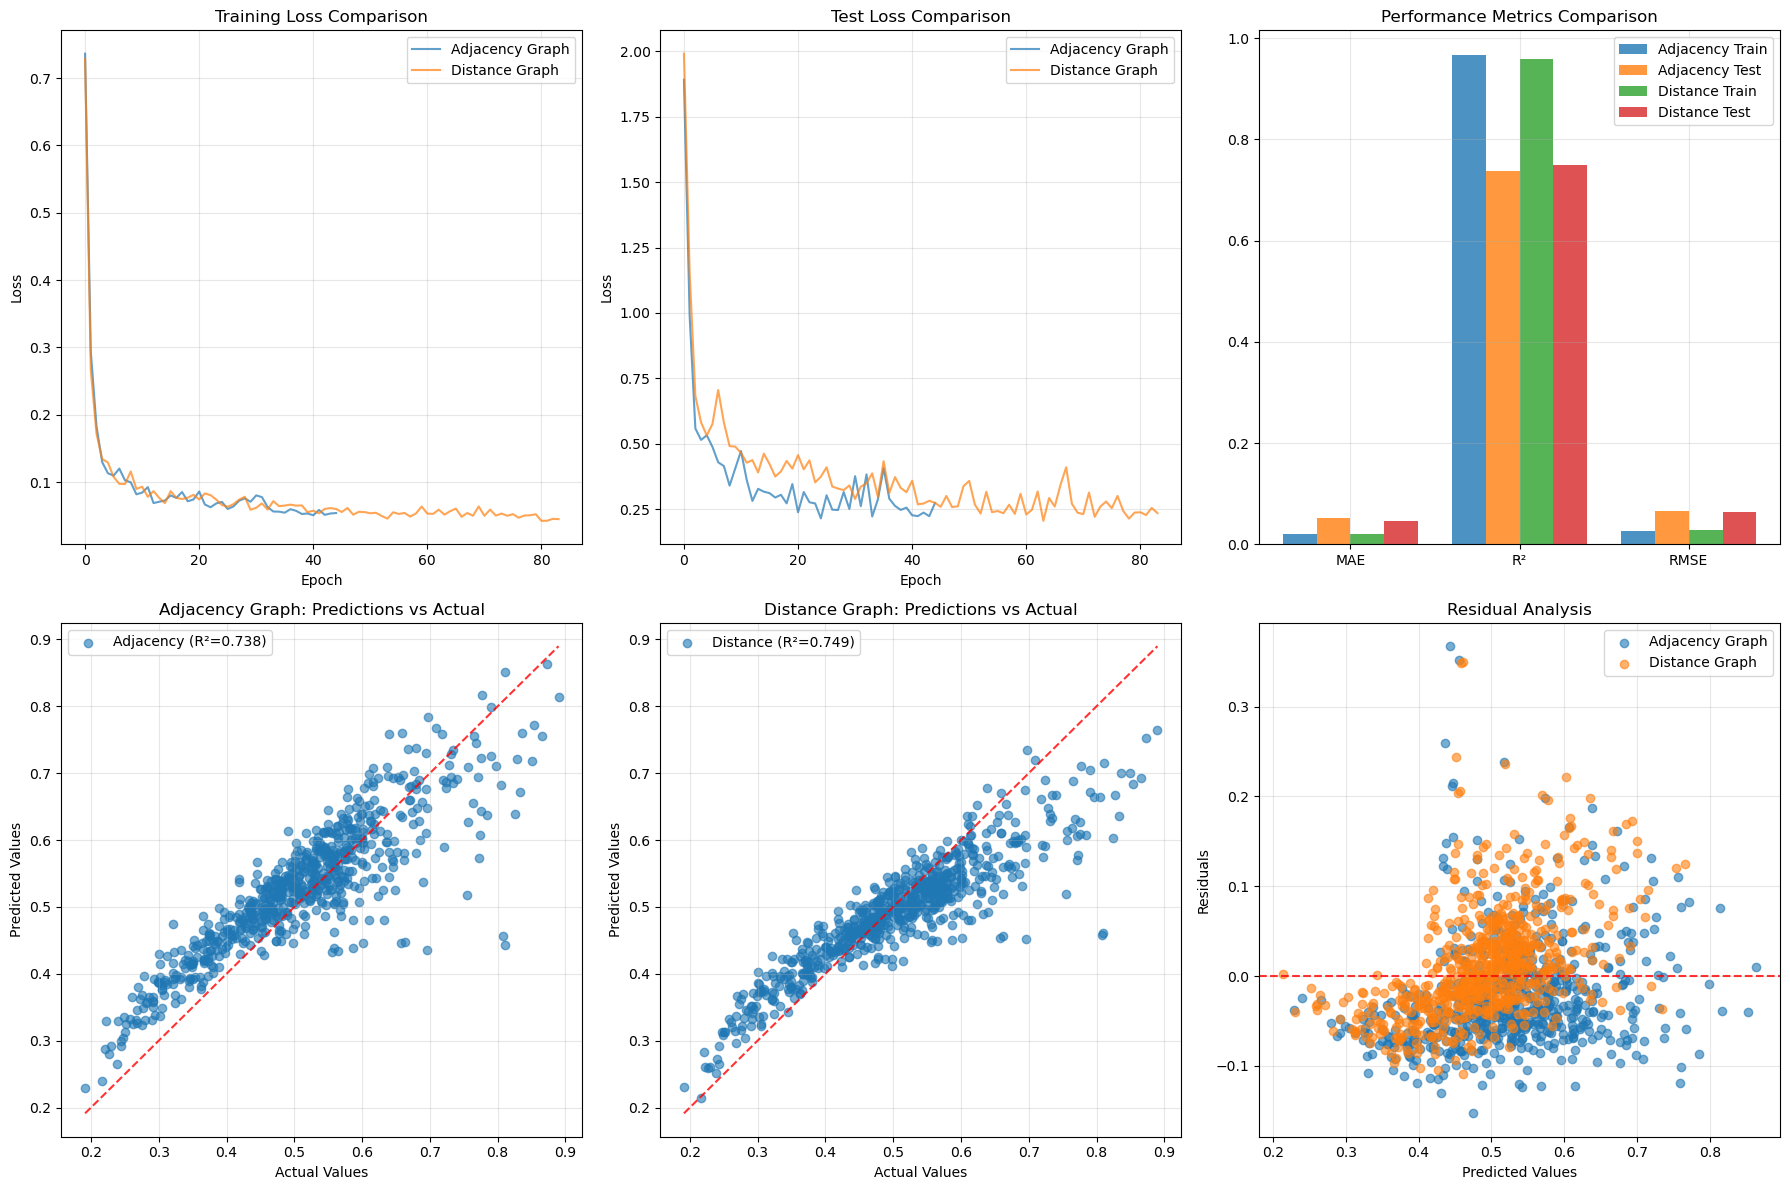


STGCN model training completed (flexible time window + past 7 days infection rate features)
Feature composition:
  - Time series features: 16 features/day × 7 days = 112 time series features
    * Original wastewater features: 15 features
    * History infection rate features: 1 feature
  - Total features: 112 features

Core strategy:
  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window
  ✓ Strict 7-day time window, do not use data from the prediction day
  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic
  ✓ Include past 7 days daily infection rate data
  ✓ Include original wastewater detection features
  ✓ Support both adjacency and distance graph structures

10. Save model results and predictions...
Adjacency graph model training epochs: 45
Distance graph model training epochs: 84
Save the first 45 epochs of training history
STGCN infection rate features model results saved:
  - Performance metrics: ../results/stgcn_versi

In [2]:
##### STGCN version 2 - Include past 7-day infection rate features

print("=== STGCN version 2 - Include past 7-day infection rate features ===")

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load data
print("\n1. Load data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()

print(f"Number of CIS regions: {len(cis_regions)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

# 2. Build graph structure
print("\n2. Build graph structure...")

def load_cis_boundaries():
    """Load CIS boundary data"""
    shp_path = '../data/raw/Boundaries data/Covid_Infection_Survey_Dec_2020_UK_BUC_-6314666778913437735/CIS_DEC_2020_UK_BUC.shp'
    cis_geo = gpd.read_file(shp_path)
    return cis_geo

def create_adjacency_graph(cis_codes, cis_geo):
    """Create adjacency graph based on geographic adjacency"""
    cis_to_idx = {cis: idx for idx, cis in enumerate(cis_codes)}
    idx_to_cis = {idx: cis for cis, idx in cis_to_idx.items()}
    
    n = len(cis_codes)
    adj_matrix = np.zeros((n, n))
    
    adjacency_count = 0
    for i, cis1 in enumerate(cis_codes):
        if cis1 in cis_geo['CIS20CD'].values:
            geom1 = cis_geo[cis_geo['CIS20CD'] == cis1].geometry.iloc[0]
            
            for j, cis2 in enumerate(cis_codes):
                if i != j and cis2 in cis_geo['CIS20CD'].values:
                    geom2 = cis_geo[cis_geo['CIS20CD'] == cis2].geometry.iloc[0]
                    
                    if geom1.touches(geom2):
                        adj_matrix[i, j] = 1
                        adjacency_count += 1
    
    print(f"  Build adjacency graph...")
    print(f"    Found {adjacency_count} adjacency relationships")
    print(f"    Average number of adjacent regions per region: {adjacency_count / n:.2f}")
    
    return adj_matrix, cis_to_idx, idx_to_cis

def create_distance_graph(cis_codes, cis_geo, k_neighbors=5):
    """Create distance graph based on k-nearest neighbors"""
    n = len(cis_codes)
    centroids = []
    
    for cis in cis_codes:
        if cis in cis_geo['CIS20CD'].values:
            geom = cis_geo[cis_geo['CIS20CD'] == cis].geometry.iloc[0]
            centroid = geom.centroid
            centroids.append([centroid.x, centroid.y])
        else:
            centroids.append([0, 0])
    
    centroids = np.array(centroids)
    distances = cdist(centroids, centroids)
    
    adj_matrix = np.zeros((n, n))
    for i in range(n):
        nearest_indices = np.argsort(distances[i])[1:k_neighbors+1]
        adj_matrix[i, nearest_indices] = 1
        adj_matrix[nearest_indices, i] = 1
    
    print(f"  Build distance graph (k={k_neighbors})...")
    print(f"    Each region connects to {k_neighbors} nearest neighbors")
    
    return adj_matrix

# Load CIS boundaries and build graphs
cis_geo = load_cis_boundaries()
cis_codes = sorted(list(cis_regions))
adjacency_adj, cis_to_idx, idx_to_cis = create_adjacency_graph(cis_codes, cis_geo)
distance_adj = create_distance_graph(cis_codes, cis_geo, k_neighbors=5)

print(f"Adjacency graph shape: {adjacency_adj.shape}")
print(f"Distance graph shape: {distance_adj.shape}")

# 3. Flexible time window data preparation (include past 7-day infection rates)
print("\n3. Build flexible time window data set...")

def create_flexible_time_window_with_infection_rates(data, window_days=7):
    """
    Create flexible time window data set, including:
    - Original features (15 features) in the past window_days days
    - Infection rate data (1 feature) in the past window_days days
    - Target: infection rate of the prediction day
    
    Core strategy:
    1. The prediction day must start from the 8th day of the data
    2. Each prediction day needs a complete 7-day history window
    3. If there is data, use it, otherwise use 0 to fill
    4. Never use any data from the prediction day or future!
    """
    
    sequences = []
    targets = []
    regions = []
    dates = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the global data time range
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predict date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Group by CIS region
    for cis in cis_codes:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range for this CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the region, to the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                sequence_features = []
                day_availability = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days ago
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # If there is data: use the real value
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features) + infection rate (1 feature) = 16 features
                        day_features = np.concatenate([
                            hist_row[original_features].values,
                            [hist_row['median_prob']]
                        ])
                        day_availability.append(1)  # Mark as data available
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0 to fill
                        day_features = np.zeros(len(original_features) + 1)  # 16 zeros
                        day_availability.append(0)  # Mark as no data
                    
                    sequence_features.append(day_features)
                    availability_stats['total_hist_days'] += 1
                
                sequence_features = np.array(sequence_features)  # shape: (window_days, 16)
                
                sequences.append(sequence_features)
                targets.append(pred_target)
                regions.append(cis)
                dates.append(current_date)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    sequences = np.array(sequences)  # shape: (n_samples, window_days, 16)
    targets = np.array(targets)
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in the data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average effective history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average samples per CIS region: {availability_stats['total_samples']/len(cis_codes):.1f}")
    
    return sequences, targets, regions, dates

# Create data set
sequences, targets, sample_regions, sample_dates = create_flexible_time_window_with_infection_rates(
    data, window_days=7
)

print(f"\n=== Data set shape ===")
print(f"  Sequence features: {sequences.shape}")  # (n_samples, 7, 16) - 16 features (15 original + 1 infection rate) per day
print(f"  Target: {targets.shape}")
print(f"  Total samples: {len(targets)}")

# Feature description
print(f"\n=== Feature composition ===")
print(f"Time series features (per sample):")
print(f"  - 15 original features + 1 infection rate = 16 features")
print(f"  - Day 2 ago: 15 original features + 1 infection rate = 16")
print(f"  - Day 3 ago: 15 original features + 1 infection rate = 16")
print(f"  - Day 4 ago: 15 original features + 1 infection rate = 16")
print(f"  - Day 5 ago: 15 original features + 1 infection rate = 16")
print(f"  - Day 6 ago: 15 original features + 1 infection rate = 16")
print(f"  - Day 7 ago: 15 original features + 1 infection rate = 16")
print(f"  - Total: 16 × 7 = 112 time series features")

print(f"\nTotal features: 112")

print(f"\n=== Strategy verification ===")
print(f"✓ Prediction day selection: start from the {7+1}th day of the data, ensure a complete history window")
print(f"✓ History window: strict 7-day time window (1-7 days before the prediction day)")
print(f"✓ Missing data handling: use 0 to fill if there is no data in the history window")
print(f"✓ Time boundary: never use data from the prediction day or future")
print(f"✓ Feature completeness: include original features + infection rate features")

# Verify time logic example
print(f"\n=== Time logic example ===")
if len(sample_dates) > 0:
    # Display the time logic of the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {targets[i]:.4f}")
        print(f"  CIS region: {sample_regions[i]}")
        print()

# Verify no future data is used
print(f"=== Time safety verification ===")
sample_dates_array = np.array(sample_dates)
min_pred_date = sample_dates_array.min()
max_pred_date = sample_dates_array.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day distance to data start: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: earliest prediction day at least on the {7+1}th day of the data")

# Time split
print("\n4. Time split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

train_sequences = sequences[train_mask]
train_targets = targets[train_mask]
train_regions = [sample_regions[i] for i in range(len(sample_regions)) if train_mask[i]]

test_sequences = sequences[test_mask]
test_targets = targets[test_mask]
test_regions = [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]]

print(f"Training set: {len(train_targets)} samples")
print(f"Test set: {len(test_targets)} samples")
print(f"Split date: {split_date}")

# Feature standardization
print("\n5. Feature standardization...")
scaler_seq = StandardScaler()
scaler_target = StandardScaler()

# Standardize sequence features (reshape to 2D for standardization)
n_train, n_days, n_features = train_sequences.shape
train_seq_2d = train_sequences.reshape(-1, n_features)
train_seq_scaled_2d = scaler_seq.fit_transform(train_seq_2d)
train_seq_scaled = train_seq_scaled_2d.reshape(n_train, n_days, n_features)

n_test = test_sequences.shape[0]
test_seq_2d = test_sequences.reshape(-1, n_features)
test_seq_scaled_2d = scaler_seq.transform(test_seq_2d)
test_seq_scaled = test_seq_scaled_2d.reshape(n_test, n_days, n_features)

# Standardize target
train_targets_scaled = scaler_target.fit_transform(train_targets.reshape(-1, 1)).flatten()
test_targets_scaled = scaler_target.transform(test_targets.reshape(-1, 1)).flatten()

print("Feature standardization completed")

# STGCN model definition
print("\n6. Define STGCN model...")

class STGCNBlock(nn.Module):
    """STGCN basic block: temporal convolution + spatial graph convolution + temporal convolution"""
    def __init__(self, in_channels, out_channels, num_nodes, kernel_size=3):
        super(STGCNBlock, self).__init__()
        
        # Temporal convolution 1
        self.temporal_conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=(0, 1))
        
        # Spatial graph convolution
        self.spatial_conv = GCNConv(out_channels, out_channels)
        
        # Temporal convolution 2
        self.temporal_conv2 = nn.Conv2d(out_channels, out_channels, (1, kernel_size), padding=(0, 1))
        
        # Residual connection
        self.residual_conv = nn.Conv2d(in_channels, out_channels, (1, 1)) if in_channels != out_channels else None
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, edge_index, edge_weight=None):
        # x shape: (batch_size, num_nodes, timesteps, features)
        batch_size, num_nodes, timesteps, features = x.shape
        
        # Residual connection
        residual = x
        
        # Convert to (batch_size, features, num_nodes, timesteps) for temporal convolution
        x = x.permute(0, 3, 1, 2)
        
        # Temporal convolution 1
        x = self.temporal_conv1(x)
        x = self.relu(x)
        
        # Convert to (batch_size, num_nodes, timesteps, features)
        x = x.permute(0, 2, 3, 1)
        
        # Spatial graph convolution (for each time step)
        spatial_out = []
        for t in range(x.shape[2]):
            # x[:, :, t, :] shape: (batch_size, num_nodes, features)
            xt = x[:, :, t, :].contiguous().view(-1, x.shape[3])  # (batch_size * num_nodes, features)
            
            # Graph convolution
            xt = self.spatial_conv(xt, edge_index, edge_weight)  # (batch_size * num_nodes, features)
            xt = self.relu(xt)
            
            # Reshape back to (batch_size, num_nodes, features)
            xt = xt.view(batch_size, num_nodes, -1)
            spatial_out.append(xt)
        
        # Stack time dimension
        x = torch.stack(spatial_out, dim=2)  # (batch_size, num_nodes, timesteps, features)
        
        # Convert for temporal convolution 2
        x = x.permute(0, 3, 1, 2)  # (batch_size, features, num_nodes, timesteps)
        x = self.temporal_conv2(x)
        x = x.permute(0, 2, 3, 1)  # (batch_size, num_nodes, timesteps, features)
        
        # Residual connection
        if self.residual_conv is not None:
            residual = residual.permute(0, 3, 1, 2)
            residual = self.residual_conv(residual)
            residual = residual.permute(0, 2, 3, 1)
        
        x = x + residual
        x = self.relu(x)
        x = self.dropout(x)
        
        return x

class STGCN_WithInfectionRates(nn.Module):
    """STGCN model - time series features with infection rates"""
    def __init__(self, num_nodes, num_time_features, num_timesteps, 
                 hidden_channels=32, num_layers=2):
        super(STGCN_WithInfectionRates, self).__init__()
        
        self.num_nodes = num_nodes
        self.num_timesteps = num_timesteps
        
        # STGCN blocks process time series features (with infection rates)
        self.stgcn_blocks = nn.ModuleList()
        
        # First layer
        self.stgcn_blocks.append(
            STGCNBlock(num_time_features, hidden_channels, num_nodes)
        )
        
        # Subsequent layers
        for _ in range(num_layers - 1):
            self.stgcn_blocks.append(
                STGCNBlock(hidden_channels, hidden_channels, num_nodes)
            )
        
        # Output layer
        stgcn_output_size = hidden_channels * num_timesteps
        
        self.output_layer = nn.Sequential(
            nn.Linear(stgcn_output_size, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, 1)
        )
        
    def forward(self, x, target_region_indices, edge_index, edge_weight=None):
        """
        x: (batch_size, num_nodes, timesteps, time_features) - time series features
        target_region_indices: (batch_size,) - target region indices
        """
        batch_size = x.shape[0]
        
        # STGCN process time series features
        for stgcn_block in self.stgcn_blocks:
            x = stgcn_block(x, edge_index, edge_weight)
        
        # Extract target region features
        target_features = []
        for i, region_idx in enumerate(target_region_indices):
            target_features.append(x[i, region_idx, :, :])  # (timesteps, features)
        
        target_features = torch.stack(target_features)  # (batch_size, timesteps, features)
        
        # Flatten time series features
        stgcn_out = target_features.flatten(start_dim=1)  # (batch_size, timesteps * features)
        
        # Output prediction
        output = self.output_layer(stgcn_out)
        
        return output.squeeze()

# Prepare training data
print("\n7. Prepare training data...")

def adjacency_to_edge_index_weight(adj_matrix):
    """Convert adjacency matrix to edge_index and edge_weight"""
    rows, cols = np.where(adj_matrix > 0)
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    edge_weight = torch.tensor(adj_matrix[rows, cols], dtype=torch.float)
    return edge_index, edge_weight

# Convert graph data
adjacency_edge_index, adjacency_edge_weight = adjacency_to_edge_index_weight(adjacency_adj)
distance_edge_index, distance_edge_weight = adjacency_to_edge_index_weight(distance_adj)

adjacency_edge_index = adjacency_edge_index.to(device)
adjacency_edge_weight = adjacency_edge_weight.to(device)
distance_edge_index = distance_edge_index.to(device)
distance_edge_weight = distance_edge_weight.to(device)

# Convert to tensor
train_seq_tensor = torch.FloatTensor(train_seq_scaled).to(device)
train_target_tensor = torch.FloatTensor(train_targets_scaled).to(device)

test_seq_tensor = torch.FloatTensor(test_seq_scaled).to(device)
test_target_tensor = torch.FloatTensor(test_targets_scaled).to(device)

# Create target region indices
train_region_indices = torch.LongTensor([cis_to_idx[region] for region in train_regions]).to(device)
test_region_indices = torch.LongTensor([cis_to_idx[region] for region in test_regions]).to(device)

print(f"Training data shape:")
print(f"  Sequence: {train_seq_tensor.shape}")
print(f"  Target: {train_target_tensor.shape}")
print(f"  Region indices: {train_region_indices.shape}")

# Check tensor dimensions
print(f"\nTensor dimensions details:")
print(f"  train_seq_tensor.shape: {train_seq_tensor.shape}")  # should be (n_samples, 7, 16)
print(f"  train_seq_tensor.ndim: {train_seq_tensor.ndim}")    # should be 3

# Model training
print("\n8. Model training...")

def train_stgcn_model(model_name, edge_index, edge_weight):
    """Train STGCN model"""
    print(f"\nTraining {model_name} model...")
    
    # Model parameters - fix dimension problem
    num_regions = len(cis_codes)
    
    # Fix: correctly get feature dimension
    if train_seq_tensor.ndim == 3:  # (n_samples, timesteps, features)
        num_time_features = train_seq_tensor.shape[2]  # 16 features (15 original + 1 infection rate)
        num_timesteps = train_seq_tensor.shape[1]  # 7 days
    else:
        print(f"Error: training sequence tensor dimension is incorrect! Dimension: {train_seq_tensor.shape}")
        return None
    
    print(f"Model parameters:")
    print(f"  Number of regions: {num_regions}")
    print(f"  Number of time features: {num_time_features}")
    print(f"  Number of time steps: {num_timesteps}")
    
    model = STGCN_WithInfectionRates(
        num_nodes=num_regions,
        num_time_features=num_time_features,
        num_timesteps=num_timesteps,
        hidden_channels=32,
        num_layers=2
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    # Training loop
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience = 20
    early_stop_counter = 0
    
    # Data loader (batch processing)
    batch_size = 32
    num_train_batches = (len(train_seq_tensor) + batch_size - 1) // batch_size
    
    for epoch in range(200):
        # Training
        model.train()
        epoch_train_loss = 0
        
        for batch_idx in range(num_train_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(train_seq_tensor))
            
            # Batch data
            batch_seq = train_seq_tensor[start_idx:end_idx]  # (batch_size, 7, 16)
            batch_target = train_target_tensor[start_idx:end_idx]
            batch_region_idx = train_region_indices[start_idx:end_idx]
            
            # Expand sequence data to (batch_size, num_nodes, timesteps, features)
            # Each sample needs to be copied to all nodes
            batch_size_actual = batch_seq.shape[0]
            batch_seq_expanded = batch_seq.unsqueeze(1).expand(-1, num_regions, -1, -1)  # (batch_size, num_nodes, 7, 16)
            
            # Forward propagation
            batch_pred = model(batch_seq_expanded, batch_region_idx, edge_index, edge_weight)
            batch_loss = criterion(batch_pred, batch_target)
            
            # Backward propagation
            optimizer.zero_grad()
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_loss += batch_loss.item()
        
        avg_train_loss = epoch_train_loss / num_train_batches
        
        # Validation
        model.eval()
        with torch.no_grad():
            test_seq_expanded = test_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
            test_pred = model(test_seq_expanded, test_region_indices, edge_index, edge_weight)
            test_loss = criterion(test_pred, test_target_tensor)
        
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss.item())
        
        scheduler.step(test_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stop_counter = 0
            # Save best model
            torch.save(model.state_dict(), f'../models/stgcn_version_2_{model_name.lower()}_with_infection_rates.pth')
        else:
            early_stop_counter += 1
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d}: Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, LR: {current_lr:.6f}")
        
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(f'../models/stgcn_version_2_{model_name.lower()}_with_infection_rates.pth'))
    model.eval()
    
    with torch.no_grad():
        # Train set prediction
        train_seq_expanded = train_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
        train_pred = model(train_seq_expanded, train_region_indices, edge_index, edge_weight)
        
        # Test set prediction
        test_seq_expanded = test_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
        test_pred = model(test_seq_expanded, test_region_indices, edge_index, edge_weight)
        
        # Inverse standardization of prediction results
        train_pred_orig = scaler_target.inverse_transform(train_pred.cpu().numpy().reshape(-1, 1)).flatten()
        test_pred_orig = scaler_target.inverse_transform(test_pred.cpu().numpy().reshape(-1, 1)).flatten()
        
        # Calculate metrics
        train_mae = mean_absolute_error(train_targets, train_pred_orig)
        train_r2 = r2_score(train_targets, train_pred_orig)
        train_rmse = np.sqrt(mean_squared_error(train_targets, train_pred_orig))
        
        test_mae = mean_absolute_error(test_targets, test_pred_orig)
        test_r2 = r2_score(test_targets, test_pred_orig)
        test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred_orig))
    
    print(f"\n{model_name} final results:")
    print(f"Train set - MAE: {train_mae:.4f}, R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
    print(f"Test set - MAE: {test_mae:.4f}, R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
    
    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_metrics': {'mae': train_mae, 'r2': train_r2, 'rmse': train_rmse},
        'test_metrics': {'mae': test_mae, 'r2': test_r2, 'rmse': test_rmse},
        'train_pred': train_pred_orig,
        'test_pred': test_pred_orig
    }

# Train two graph models
adjacency_results = train_stgcn_model("Adjacency", adjacency_edge_index, adjacency_edge_weight)
distance_results = train_stgcn_model("Distance", distance_edge_index, distance_edge_weight)

# Result visualization
print("\n9. Result visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training loss comparison
axes[0, 0].plot(adjacency_results['train_losses'], label='Adjacency Graph', alpha=0.7)
axes[0, 0].plot(distance_results['train_losses'], label='Distance Graph', alpha=0.7)
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test loss comparison
axes[0, 1].plot(adjacency_results['test_losses'], label='Adjacency Graph', alpha=0.7)
axes[0, 1].plot(distance_results['test_losses'], label='Distance Graph', alpha=0.7)
axes[0, 1].set_title('Test Loss Comparison')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
adjacency_train_vals = [adjacency_results['train_metrics']['mae'], 
                       adjacency_results['train_metrics']['r2'], 
                       adjacency_results['train_metrics']['rmse']]
adjacency_test_vals = [adjacency_results['test_metrics']['mae'], 
                      adjacency_results['test_metrics']['r2'], 
                      adjacency_results['test_metrics']['rmse']]
distance_train_vals = [distance_results['train_metrics']['mae'], 
                      distance_results['train_metrics']['r2'], 
                      distance_results['train_metrics']['rmse']]
distance_test_vals = [distance_results['test_metrics']['mae'], 
                     distance_results['test_metrics']['r2'], 
                     distance_results['test_metrics']['rmse']]

x = np.arange(len(metrics))
width = 0.2

axes[0, 2].bar(x - 1.5*width, adjacency_train_vals, width, label='Adjacency Train', alpha=0.8)
axes[0, 2].bar(x - 0.5*width, adjacency_test_vals, width, label='Adjacency Test', alpha=0.8)
axes[0, 2].bar(x + 0.5*width, distance_train_vals, width, label='Distance Train', alpha=0.8)
axes[0, 2].bar(x + 1.5*width, distance_test_vals, width, label='Distance Test', alpha=0.8)
axes[0, 2].set_title('Performance Metrics Comparison')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(metrics)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Predictions vs actual values scatter plot
axes[1, 0].scatter(test_targets, adjacency_results['test_pred'], alpha=0.6, label=f"Adjacency (R²={adjacency_results['test_metrics']['r2']:.3f})")
axes[1, 0].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 0].set_title('Adjacency Graph: Predictions vs Actual')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(test_targets, distance_results['test_pred'], alpha=0.6, label=f"Distance (R²={distance_results['test_metrics']['r2']:.3f})")
axes[1, 1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 1].set_title('Distance Graph: Predictions vs Actual')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
adjacency_residuals = test_targets - adjacency_results['test_pred']
distance_residuals = test_targets - distance_results['test_pred']

axes[1, 2].scatter(adjacency_results['test_pred'], adjacency_residuals, alpha=0.6, label='Adjacency Graph')
axes[1, 2].scatter(distance_results['test_pred'], distance_residuals, alpha=0.6, label='Distance Graph')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/stgcn_version_2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("STGCN model training completed (flexible time window + past 7 days infection rate features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 16 features/day × 7 days = 112 time series features")
print(f"    * Original wastewater features: {len(original_features)} features")
print(f"    * History infection rate features: 1 feature")
print(f"  - Total features: 112 features")
print(f"\nCore strategy:")
print(f"  ✓ Prediction day starts from the 8th day of the data, ensure a complete history window")
print(f"  ✓ Strict 7-day time window, do not use data from the prediction day")
print(f"  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic")
print(f"  ✓ Include past 7 days daily infection rate data")
print(f"  ✓ Include original wastewater detection features")
print(f"  ✓ Support both adjacency and distance graph structures")
print("="*80)

# Save model results and predictions
print("\n10. Save model results and predictions...")

# Save performance metrics summary
metrics_summary = pd.DataFrame({
    'model_type': ['STGCN_Adjacency_InfectionRates', 'STGCN_Distance_InfectionRates'],
    'train_mae': [adjacency_results['train_metrics']['mae'], distance_results['train_metrics']['mae']],
    'train_r2': [adjacency_results['train_metrics']['r2'], distance_results['train_metrics']['r2']],
    'train_rmse': [adjacency_results['train_metrics']['rmse'], distance_results['train_metrics']['rmse']],
    'test_mae': [adjacency_results['test_metrics']['mae'], distance_results['test_metrics']['mae']],
    'test_r2': [adjacency_results['test_metrics']['r2'], distance_results['test_metrics']['r2']],
    'test_rmse': [adjacency_results['test_metrics']['rmse'], distance_results['test_metrics']['rmse']],
    'feature_count': [112, 112],  # 16 features × 7 days
    'sample_count': [len(test_targets), len(test_targets)]
})
metrics_summary.to_csv('../results/stgcn_version_2_infection_rates_metrics_summary.csv', index=False)

# Save predictions - adjacency graph model
adjacency_predictions = pd.DataFrame({
    'actual': test_targets,
    'predicted': adjacency_results['test_pred'],
    'residual': test_targets - adjacency_results['test_pred'],
    'date': [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]],
    'cis_code': [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]],
    'model_type': 'STGCN_Adjacency_InfectionRates'
})
adjacency_predictions.to_csv('../results/stgcn_version_2_adjacency_infection_rates_predictions.csv', index=False)

# Save predictions - distance graph model
distance_predictions = pd.DataFrame({
    'actual': test_targets,
    'predicted': distance_results['test_pred'],
    'residual': test_targets - distance_results['test_pred'],
    'date': [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]],
    'cis_code': [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]],
    'model_type': 'STGCN_Distance_InfectionRates'
})
distance_predictions.to_csv('../results/stgcn_version_2_distance_infection_rates_predictions.csv', index=False)

# Save training history - fix length inconsistency problem
print(f"Adjacency graph model training epochs: {len(adjacency_results['train_losses'])}")
print(f"Distance graph model training epochs: {len(distance_results['train_losses'])}")

# Get the shortest training history length
min_epochs = min(len(adjacency_results['train_losses']), len(distance_results['train_losses']))
print(f"Save the first {min_epochs} epochs of training history")

training_history = pd.DataFrame({
    'epoch': range(min_epochs),
    'adjacency_train_loss': adjacency_results['train_losses'][:min_epochs],
    'adjacency_test_loss': adjacency_results['test_losses'][:min_epochs],
    'distance_train_loss': distance_results['train_losses'][:min_epochs],
    'distance_test_loss': distance_results['test_losses'][:min_epochs]
})
training_history.to_csv('../results/stgcn_version_2_infection_rates_training_history.csv', index=False)

# If you need to save the complete training history, you can save it separately
adjacency_history = pd.DataFrame({
    'epoch': range(len(adjacency_results['train_losses'])),
    'train_loss': adjacency_results['train_losses'],
    'test_loss': adjacency_results['test_losses']
})
adjacency_history.to_csv('../results/stgcn_version_2_adjacency_infection_rates_full_training_history.csv', index=False)

distance_history = pd.DataFrame({
    'epoch': range(len(distance_results['train_losses'])),
    'train_loss': distance_results['train_losses'],
    'test_loss': distance_results['test_losses']
})
distance_history.to_csv('../results/stgcn_version_2_distance_infection_rates_full_training_history.csv', index=False)

print("STGCN infection rate features model results saved:")
print("  - Performance metrics: ../results/stgcn_version_2_infection_rates_metrics_summary.csv")
print("  - Adjacency graph predictions: ../results/stgcn_version_2_adjacency_infection_rates_predictions.csv")  
print("  - Distance graph predictions: ../results/stgcn_version_2_distance_infection_rates_predictions.csv")
print("  - Merged training history: ../results/stgcn_version_2_infection_rates_training_history.csv")
print("  - Adjacency graph full training history: ../results/stgcn_version_2_adjacency_infection_rates_full_training_history.csv")
print("  - Distance graph full training history: ../results/stgcn_version_2_distance_infection_rates_full_training_history.csv")

=== STGCN version 3 - Include past 7-day infection rate features + infection rate derived features ===
Using device: cpu

1. Load data...
Data shape: (2398, 20)
Date range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

2. Build graph structure...
  Build adjacency graph...
    Found 124 adjacency relationships
    Average number of adjacent regions per region: 4.59
  Build distance graph (k=5)...
    Each region connects to 5 nearest neighbors
Adjacency graph shape: (27, 27)
Distance graph shape: (27, 27)

3. Prepare flexible time window data...
Time range analysis:


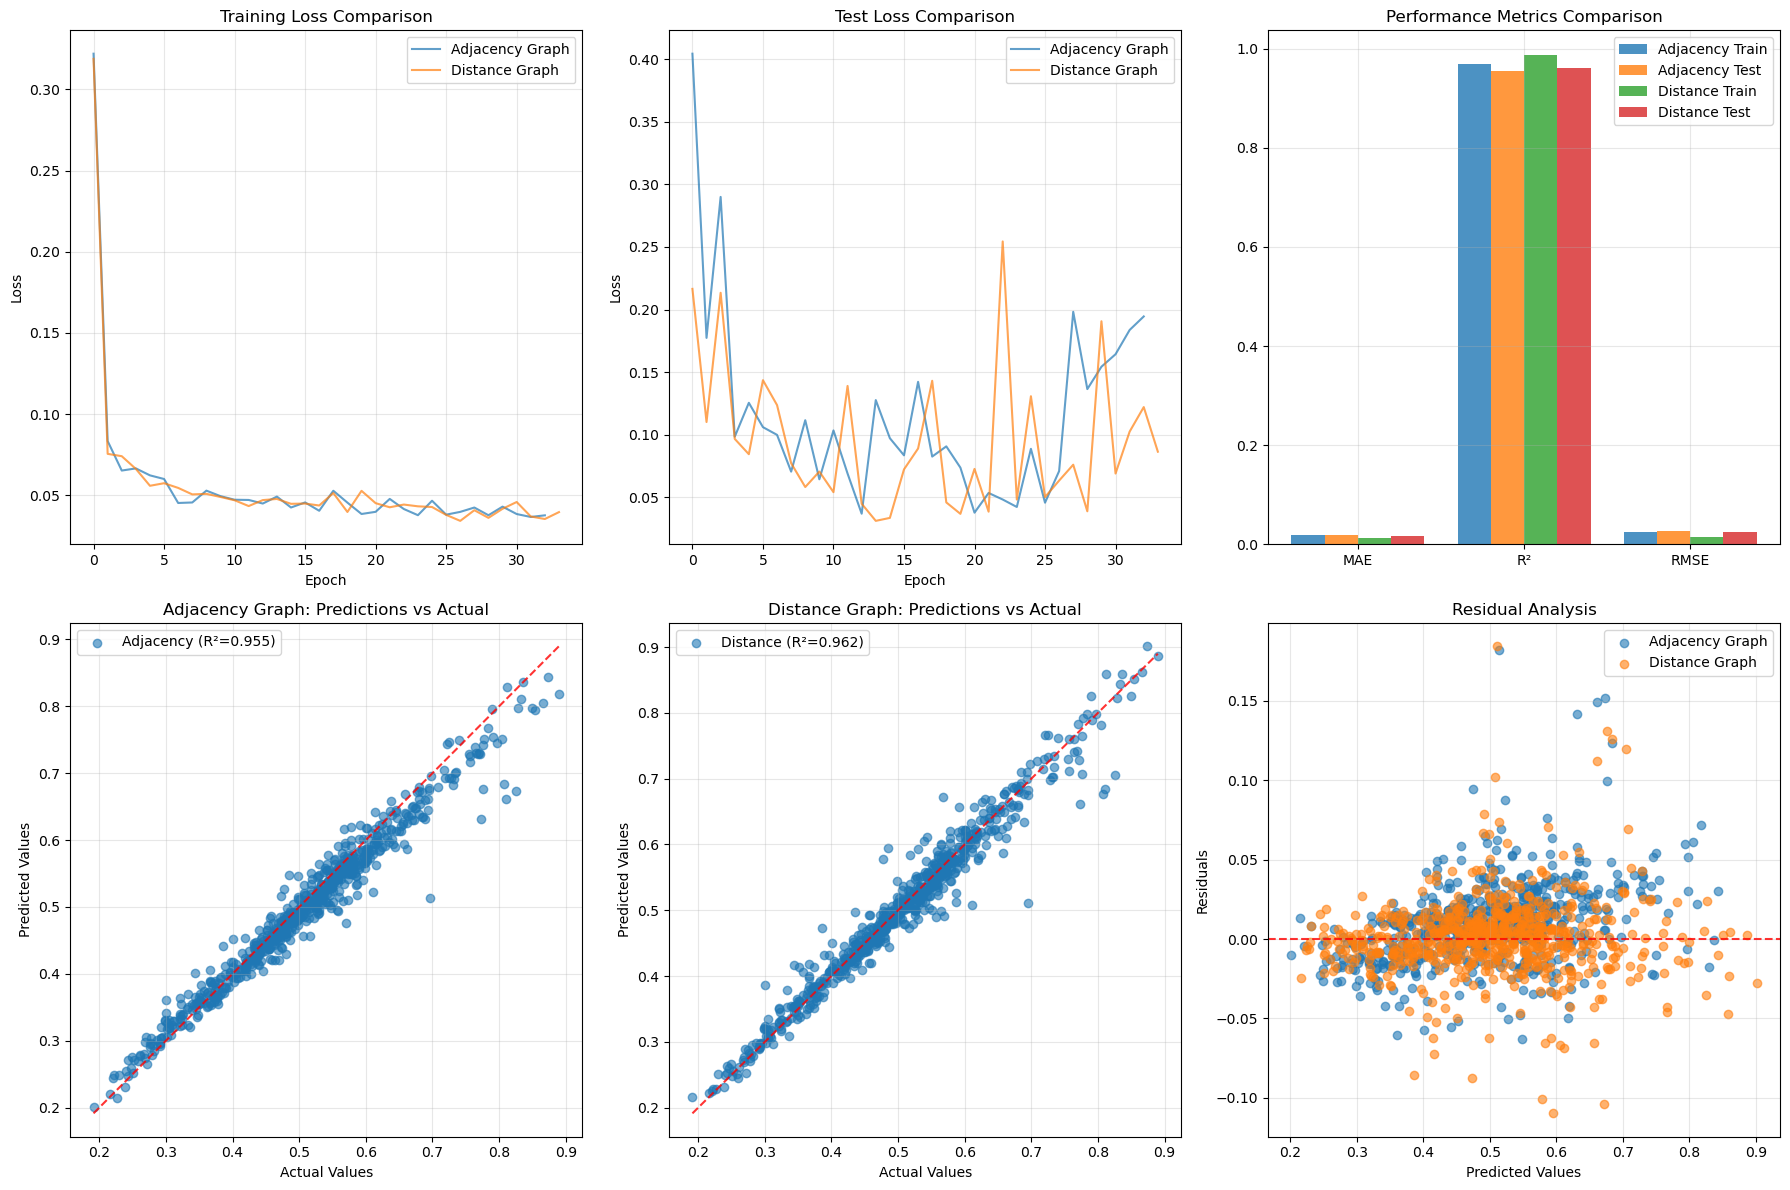


STGCN model training completed (flexible time window + past 7 days infection rate features + derived features)
Feature composition:
  - Time series features: 27 features/day × 7 days = 189 time series features
    * Original wastewater features: 15
    * Historical infection rate features: 1
    * Infection rate derived features: 11
  - Total features: 189

Core strategies:
  ✓ Predict from day 8 of data to ensure full history window
  ✓ Strict 7-day time window, no use of prediction day data
  ✓ Flexible handling of missing data, use 0 to maintain time logic
  ✓ Include infection rate data for past 7 days
  ✓ Include 11 derived features based on historical infection rates
  ✓ Include original wastewater detection features
  ✓ Support both adjacency and distance graph structures

10. Save model results and predictions...
Adjacency graph model training epochs: 33
Distance graph model training epochs: 34
Save the first 33 epochs of training history
STGCN infection rate derived features 

In [3]:
##### STGCN version 3 - Include past 7-day infection rate features + infection rate derived features

print("=== STGCN version 3 - Include past 7-day infection rate features + infection rate derived features ===")

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load data
print("\n1. Load data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()

print(f"Number of CIS regions: {len(cis_regions)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

# 2. Build graph structure
print("\n2. Build graph structure...")

def load_cis_boundaries():
    """Load CIS boundary data"""
    shp_path = '../data/raw/Boundaries data/Covid_Infection_Survey_Dec_2020_UK_BUC_-6314666778913437735/CIS_DEC_2020_UK_BUC.shp'
    cis_geo = gpd.read_file(shp_path)
    return cis_geo

def create_adjacency_graph(cis_codes, cis_geo):
    """Create adjacency graph based on geographic adjacency"""
    cis_to_idx = {cis: idx for idx, cis in enumerate(cis_codes)}
    idx_to_cis = {idx: cis for cis, idx in cis_to_idx.items()}
    
    n = len(cis_codes)
    adj_matrix = np.zeros((n, n))
    
    adjacency_count = 0
    for i, cis1 in enumerate(cis_codes):
        if cis1 in cis_geo['CIS20CD'].values:
            geom1 = cis_geo[cis_geo['CIS20CD'] == cis1].geometry.iloc[0]
            
            for j, cis2 in enumerate(cis_codes):
                if i != j and cis2 in cis_geo['CIS20CD'].values:
                    geom2 = cis_geo[cis_geo['CIS20CD'] == cis2].geometry.iloc[0]
                    
                    if geom1.touches(geom2):
                        adj_matrix[i, j] = 1
                        adjacency_count += 1
    
    print(f"  Build adjacency graph...")
    print(f"    Found {adjacency_count} adjacency relationships")
    print(f"    Average number of adjacent regions per region: {adjacency_count / n:.2f}")
    
    return adj_matrix, cis_to_idx, idx_to_cis

def create_distance_graph(cis_codes, cis_geo, k_neighbors=5):
    """Create k-nearest neighbor graph based on distance"""
    n = len(cis_codes)
    centroids = []
    
    for cis in cis_codes:
        if cis in cis_geo['CIS20CD'].values:
            geom = cis_geo[cis_geo['CIS20CD'] == cis].geometry.iloc[0]
            centroid = geom.centroid
            centroids.append([centroid.x, centroid.y])
        else:
            centroids.append([0, 0])
    
    centroids = np.array(centroids)
    distances = cdist(centroids, centroids)
    
    adj_matrix = np.zeros((n, n))
    for i in range(n):
        nearest_indices = np.argsort(distances[i])[1:k_neighbors+1]
        adj_matrix[i, nearest_indices] = 1
        adj_matrix[nearest_indices, i] = 1
    
    print(f"  Build distance graph (k={k_neighbors})...")
    print(f"    Each region connects to {k_neighbors} nearest neighbors")
    
    return adj_matrix

# Load CIS boundaries and build graph
cis_geo = load_cis_boundaries()
cis_codes = sorted(list(cis_regions))
adjacency_adj, cis_to_idx, idx_to_cis = create_adjacency_graph(cis_codes, cis_geo)
distance_adj = create_distance_graph(cis_codes, cis_geo, k_neighbors=5)

print(f"Adjacency graph shape: {adjacency_adj.shape}")
print(f"Distance graph shape: {distance_adj.shape}")

# 3. Prepare flexible time window data (include past 7 days infection rate + infection rate derived features)
print("\n3. Prepare flexible time window data...")

def calculate_infection_rate_derived_features(infection_rates, availability_flags):
    """
    Calculate derived features based on past 7 days infection rates
    
    Parameters:
    - infection_rates: list of infection rates for the past 7 days [day1, day2, ..., day7] (most recent to oldest)
    - availability_flags: list of data availability flags corresponding to the infection rates
    
    Returns:
    - derived features dictionary
    """
    # Only use infection rates with data
    valid_rates = [rate for rate, flag in zip(infection_rates, availability_flags) if flag == 1]
    
    derived_features = {}
    
    if len(valid_rates) == 0:
        # If there is no valid data, all derived features are 0
        derived_features = {
            'infection_rate_mean_7d': 0.0,
            'infection_rate_std_7d': 0.0,
            'infection_rate_trend_7d': 0.0,
            'infection_rate_max_7d': 0.0,
            'infection_rate_min_7d': 0.0,
            'infection_rate_range_7d': 0.0,
            'infection_rate_recent_3d_mean': 0.0,
            'infection_rate_change_1d': 0.0,
            'infection_rate_change_3d': 0.0,
            'infection_rate_volatility_7d': 0.0,
            'infection_rate_momentum_7d': 0.0
        }
    else:
        # Basic statistical features
        derived_features['infection_rate_mean_7d'] = np.mean(valid_rates)
        derived_features['infection_rate_std_7d'] = np.std(valid_rates) if len(valid_rates) > 1 else 0.0
        derived_features['infection_rate_max_7d'] = np.max(valid_rates)
        derived_features['infection_rate_min_7d'] = np.min(valid_rates)
        derived_features['infection_rate_range_7d'] = derived_features['infection_rate_max_7d'] - derived_features['infection_rate_min_7d']
        
        # Trend features (linear regression slope)
        if len(valid_rates) >= 2:
            x = np.arange(len(valid_rates))
            slope, _ = np.polyfit(x, valid_rates, 1)
            derived_features['infection_rate_trend_7d'] = slope
        else:
            derived_features['infection_rate_trend_7d'] = 0.0
        
        # Recent features (mean of the past 3 days)
        recent_3d_rates = [rate for rate, flag in zip(infection_rates[:3], availability_flags[:3]) if flag == 1]
        derived_features['infection_rate_recent_3d_mean'] = np.mean(recent_3d_rates) if recent_3d_rates else 0.0
        
        # Change features
        if len(valid_rates) >= 2:
            # 1 day change (today - yesterday)
            if availability_flags[0] == 1 and availability_flags[1] == 1:
                derived_features['infection_rate_change_1d'] = infection_rates[0] - infection_rates[1]
            else:
                derived_features['infection_rate_change_1d'] = 0.0
            
            # 3 day change (mean of the past 3 days - mean of the past 4-6 days)
            recent_3d = [rate for rate, flag in zip(infection_rates[:3], availability_flags[:3]) if flag == 1]
            earlier_3d = [rate for rate, flag in zip(infection_rates[3:6], availability_flags[3:6]) if flag == 1]
            
            if recent_3d and earlier_3d:
                derived_features['infection_rate_change_3d'] = np.mean(recent_3d) - np.mean(earlier_3d)
            else:
                derived_features['infection_rate_change_3d'] = 0.0
        else:
            derived_features['infection_rate_change_1d'] = 0.0
            derived_features['infection_rate_change_3d'] = 0.0
        
        # Volatility features (relative standard deviation)
        if derived_features['infection_rate_mean_7d'] > 0:
            derived_features['infection_rate_volatility_7d'] = derived_features['infection_rate_std_7d'] / derived_features['infection_rate_mean_7d']
        else:
            derived_features['infection_rate_volatility_7d'] = 0.0
        
        # Momentum features (weighted average, recent days have higher weight)
        if len(valid_rates) >= 3:
            weights = np.array([0.4, 0.3, 0.2, 0.1][:len(valid_rates)])
            weights = weights / weights.sum()
            derived_features['infection_rate_momentum_7d'] = np.average(valid_rates[:len(weights)], weights=weights)
        else:
            derived_features['infection_rate_momentum_7d'] = derived_features['infection_rate_mean_7d']
    
    return derived_features

def create_flexible_time_window_with_infection_rates_and_derived(data, window_days=7):
    """
    Create flexible time window dataset, including:
    - Original features (15 features) within the past window_days days
    - Infection rate data (1 feature) within the past window_days days
    - Derived features based on past 7 days infection rates (11 features)
    - Target: infection rate for the prediction day
    
    Core strategy:
    1. Prediction day must start from the 8th day of the data
    2. Each prediction day needs to have a complete 7-day history window
    3. Use data if available, otherwise use 0
    4. Never use data from the prediction day or future
    5. Derived features are completely based on historical infection rate data
    """
    
    sequences = []
    targets = []
    regions = []
    dates = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date in data: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date in data: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest possible prediction date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Group by CIS region
    for cis in cis_codes:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the region, to the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                sequence_features = []
                day_availability = []
                infection_rates_history = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days ago
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # Data available: use real value
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features) + infection rate (1 feature) = 16 features
                        day_features = np.concatenate([
                            hist_row[original_features].values,
                            [hist_row['median_prob']]
                        ])
                        day_availability.append(1)  # Mark as data available
                        infection_rates_history.append(hist_row['median_prob'])
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0
                        day_features = np.zeros(len(original_features) + 1)  # 16 zeros
                        day_availability.append(0)  # Mark as no data
                        infection_rates_history.append(0.0)
                    
                    sequence_features.append(day_features)
                    availability_stats['total_hist_days'] += 1
                
                # Calculate infection rate derived features (based on historical 7 days data)
                derived_features = calculate_infection_rate_derived_features(
                    infection_rates_history, day_availability
                )
                
                # Add derived features to each day's features
                derived_feature_values = list(derived_features.values())  # 11 derived features
                
                # Add derived features to each day
                enhanced_sequence_features = []
                for day_features in sequence_features:
                    enhanced_day_features = np.concatenate([
                        day_features,  # 16 features (15 original + 1 infection rate)
                        derived_feature_values  # 11 derived features
                    ])  # 27 features
                    enhanced_sequence_features.append(enhanced_day_features)
                
                enhanced_sequence_features = np.array(enhanced_sequence_features)  # shape: (window_days, 27)
                
                sequences.append(enhanced_sequence_features)
                targets.append(pred_target)
                regions.append(cis)
                dates.append(current_date)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    sequences = np.array(sequences)  # shape: (n_samples, window_days, 27)
    targets = np.array(targets)
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average number of valid history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average number of samples per CIS region: {availability_stats['total_samples']/len(cis_codes):.1f}")
    
    # Print derived features list
    sample_derived = calculate_infection_rate_derived_features([0.1]*7, [1]*7)
    print(f"\nInfection rate derived features ({len(sample_derived)} features):")
    for i, feature_name in enumerate(sample_derived.keys(), 1):
        print(f"  {i:2d}. {feature_name}")
    
    return sequences, targets, regions, dates

# Create dataset
sequences, targets, sample_regions, sample_dates = create_flexible_time_window_with_infection_rates_and_derived(
    data, window_days=7
)

print(f"\n=== Dataset shape ===")
print(f"  Sequence features: {sequences.shape}")  # (n_samples, 7, 27) - 27 features (15 original + 1 infection rate + 11 derived) per day
print(f"  Target: {targets.shape}")
print(f"  Total samples: {len(targets)}")

# Feature description
print(f"\n=== Feature composition ===")
print(f"Time series features (each sample):")
print(f"  - 1 day ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 2 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 3 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 4 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 5 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 6 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  - 7 days ago: 15 original features + 1 infection rate + 11 derived features = 27 features")
print(f"  Total: 27 × 7 = 189 features")

print(f"\nTotal features: 189")

print(f"\n=== Derived feature description ===")
print(f"Infection rate derived features (based on past 7 days history data):")
print(f"  1. infection_rate_mean_7d: 7 days infection rate mean")
print(f"  2. infection_rate_std_7d: 7 days infection rate standard deviation")
print(f"  3. infection_rate_trend_7d: 7 days infection rate trend (linear regression slope)")
print(f"  4. infection_rate_max_7d: 7 days infection rate maximum")
print(f"  5. infection_rate_min_7d: 7 days infection rate minimum")
print(f"  6. infection_rate_range_7d: 7 days infection rate range")
print(f"  7. infection_rate_recent_3d_mean: 3 days infection rate mean")
print(f"  8. infection_rate_change_1d: 1 day change (today - yesterday)")
print(f"  9. infection_rate_change_3d: 3 days change (mean of the past 3 days - mean of the past 4-6 days)") 
print(f"  10. infection_rate_volatility_7d: 7 days volatility (relative standard deviation)")
print(f"  11. infection_rate_momentum_7d: 7 days momentum (weighted average)")

print(f"\n=== Strategy validation ===")
print(f"✓ Prediction day selection: Start from the {7+1}th day of the data, ensuring a complete history window")
print(f"✓ History window: Strict 7-day time window (1-7 days before the prediction day)")
print(f"✓ Missing data: Use 0 for days with no data in the history window")
print(f"✓ Time boundary: Never use data from the prediction day or future")
print(f"✓ Feature completeness: Original features + infection rate + derived features")
print(f"✓ Derived features: Completely based on historical 7 days infection rate data")

# Validate time logic
print(f"\n=== Time logic example ===")
if len(sample_dates) > 0:
    # Show time logic for the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {targets[i]:.4f}")
        print(f"  CIS region: {sample_regions[i]}")
        print()

# Validate no future data
print(f"=== Time safety validation ===")
sample_dates_array = np.array(sample_dates)
min_pred_date = sample_dates_array.min()
max_pred_date = sample_dates_array.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day distance from data start: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: Earliest prediction day is at least {7+1} days from the start of the data")

# Time split
print("\n4. Time split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

train_sequences = sequences[train_mask]
train_targets = targets[train_mask]
train_regions = [sample_regions[i] for i in range(len(sample_regions)) if train_mask[i]]

test_sequences = sequences[test_mask]
test_targets = targets[test_mask]
test_regions = [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]]

print(f"Training set: {len(train_targets)} samples")
print(f"Test set: {len(test_targets)} samples")
print(f"Split date: {split_date}")

# Feature standardization
print("\n5. Feature standardization...")
scaler_seq = StandardScaler()
scaler_target = StandardScaler()

# Standardize sequence features (reshape to 2D for standardization)
n_train, n_days, n_features = train_sequences.shape
train_seq_2d = train_sequences.reshape(-1, n_features)
train_seq_scaled_2d = scaler_seq.fit_transform(train_seq_2d)
train_seq_scaled = train_seq_scaled_2d.reshape(n_train, n_days, n_features)

n_test = test_sequences.shape[0]
test_seq_2d = test_sequences.reshape(-1, n_features)
test_seq_scaled_2d = scaler_seq.transform(test_seq_2d)
test_seq_scaled = test_seq_scaled_2d.reshape(n_test, n_days, n_features)

# Standardize target
train_targets_scaled = scaler_target.fit_transform(train_targets.reshape(-1, 1)).flatten()
test_targets_scaled = scaler_target.transform(test_targets.reshape(-1, 1)).flatten()

print("Feature standardization completed")

# STGCN model definition
print("\n6. Define STGCN model...")

class STGCNBlock(nn.Module):
    """STGCN basic block: temporal convolution + spatial graph convolution + temporal convolution"""
    def __init__(self, in_channels, out_channels, num_nodes, kernel_size=3):
        super(STGCNBlock, self).__init__()
        
        # Temporal convolution 1
        self.temporal_conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=(0, 1))
        
        # Spatial graph convolution
        self.spatial_conv = GCNConv(out_channels, out_channels)
        
        # Temporal convolution 2
        self.temporal_conv2 = nn.Conv2d(out_channels, out_channels, (1, kernel_size), padding=(0, 1))
        
        # Residual connection
        self.residual_conv = nn.Conv2d(in_channels, out_channels, (1, 1)) if in_channels != out_channels else None
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, edge_index, edge_weight=None):
        # x shape: (batch_size, num_nodes, timesteps, features)
        batch_size, num_nodes, timesteps, features = x.shape
        
        # Residual connection
        residual = x
        
        # Convert to (batch_size, features, num_nodes, timesteps) for temporal convolution
        x = x.permute(0, 3, 1, 2)
        
        # Temporal convolution 1
        x = self.temporal_conv1(x)
        x = self.relu(x)
        
        # Convert to (batch_size, num_nodes, timesteps, features)
        x = x.permute(0, 2, 3, 1)
        
        # Spatial graph convolution (for each time step)
        spatial_out = []
        for t in range(x.shape[2]):
            # x[:, :, t, :] shape: (batch_size, num_nodes, features)
            xt = x[:, :, t, :].contiguous().view(-1, x.shape[3])  # (batch_size * num_nodes, features)
            
            # Graph convolution
            xt = self.spatial_conv(xt, edge_index, edge_weight)  # (batch_size * num_nodes, features)
            xt = self.relu(xt)
            
            # Reshape back to (batch_size, num_nodes, features)
            xt = xt.view(batch_size, num_nodes, -1)
            spatial_out.append(xt)
        
        # Stack time dimension
        x = torch.stack(spatial_out, dim=2)  # (batch_size, num_nodes, timesteps, features)
        
        # Convert to (batch_size, features, num_nodes, timesteps) for temporal convolution 2
        x = x.permute(0, 3, 1, 2)  # (batch_size, features, num_nodes, timesteps)
        x = self.temporal_conv2(x)
        x = x.permute(0, 2, 3, 1)  # (batch_size, num_nodes, timesteps, features)
        
        # Residual connection
        if self.residual_conv is not None:
            residual = residual.permute(0, 3, 1, 2)
            residual = self.residual_conv(residual)
            residual = residual.permute(0, 2, 3, 1)
        
        x = x + residual
        x = self.relu(x)
        x = self.dropout(x)
        
        return x

class STGCN_WithInfectionRatesAndDerived(nn.Module):
    """STGCN model - time series features including infection rates and derived features"""
    def __init__(self, num_nodes, num_time_features, num_timesteps, 
                 hidden_channels=32, num_layers=2):
        super(STGCN_WithInfectionRatesAndDerived, self).__init__()
        
        self.num_nodes = num_nodes
        self.num_timesteps = num_timesteps
        
        # STGCN block processes time series features (including infection rates and derived features)
        self.stgcn_blocks = nn.ModuleList()
        
        # First layer
        self.stgcn_blocks.append(
            STGCNBlock(num_time_features, hidden_channels, num_nodes)
        )
        
        # Subsequent layers
        for _ in range(num_layers - 1):
            self.stgcn_blocks.append(
                STGCNBlock(hidden_channels, hidden_channels, num_nodes)
            )
        
        # Output layer
        stgcn_output_size = hidden_channels * num_timesteps
        
        self.output_layer = nn.Sequential(
            nn.Linear(stgcn_output_size, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, 1)
        )
        
    def forward(self, x, target_region_indices, edge_index, edge_weight=None):
        """
        x: (batch_size, num_nodes, timesteps, time_features) - time series features
        target_region_indices: (batch_size,) - target region indices
        """
        batch_size = x.shape[0]
        
        # STGCN processes time series features
        for stgcn_block in self.stgcn_blocks:
            x = stgcn_block(x, edge_index, edge_weight)
        
        # Extract features for target regions
        target_features = []
        for i, region_idx in enumerate(target_region_indices):
            target_features.append(x[i, region_idx, :, :])  # (timesteps, features)
        
        target_features = torch.stack(target_features)  # (batch_size, timesteps, features)
        
        # Flatten time series features
        stgcn_out = target_features.flatten(start_dim=1)  # (batch_size, timesteps * features)
        
        # Output prediction
        output = self.output_layer(stgcn_out)
        
        return output.squeeze()

# Prepare training data
print("\n7. Prepare training data...")

def adjacency_to_edge_index_weight(adj_matrix):
    """Convert adjacency matrix to edge_index and edge_weight"""
    rows, cols = np.where(adj_matrix > 0)
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    edge_weight = torch.tensor(adj_matrix[rows, cols], dtype=torch.float)
    return edge_index, edge_weight

# Convert graph data
adjacency_edge_index, adjacency_edge_weight = adjacency_to_edge_index_weight(adjacency_adj)
distance_edge_index, distance_edge_weight = adjacency_to_edge_index_weight(distance_adj)

adjacency_edge_index = adjacency_edge_index.to(device)
adjacency_edge_weight = adjacency_edge_weight.to(device)
distance_edge_index = distance_edge_index.to(device)
distance_edge_weight = distance_edge_weight.to(device)

# Convert to tensor
train_seq_tensor = torch.FloatTensor(train_seq_scaled).to(device)
train_target_tensor = torch.FloatTensor(train_targets_scaled).to(device)

test_seq_tensor = torch.FloatTensor(test_seq_scaled).to(device)
test_target_tensor = torch.FloatTensor(test_targets_scaled).to(device)

# Create target region indices
train_region_indices = torch.LongTensor([cis_to_idx[region] for region in train_regions]).to(device)
test_region_indices = torch.LongTensor([cis_to_idx[region] for region in test_regions]).to(device)

print(f"Training data shape:")
print(f"  Sequence: {train_seq_tensor.shape}")
print(f"  Target: {train_target_tensor.shape}")
print(f"  Region indices: {train_region_indices.shape}")

# Check tensor dimensions
print(f"\nTensor dimensions:")
print(f"  train_seq_tensor.shape: {train_seq_tensor.shape}")  # should be (n_samples, 7, 27)
print(f"  train_seq_tensor.ndim: {train_seq_tensor.ndim}")    # should be 3

# Model training
print("\n8. Model training...")

def train_stgcn_model(model_name, edge_index, edge_weight):
    """Train STGCN model"""
    print(f"\nTraining {model_name} model...")
    
    # Model parameters - fix dimension problem
    num_regions = len(cis_codes)
    
    # Fix: correctly get feature dimensions
    if train_seq_tensor.ndim == 3:  # (n_samples, timesteps, features)
        num_time_features = train_seq_tensor.shape[2]  # 27 features (15 original + 1 infection rate + 11 derived)
        num_timesteps = train_seq_tensor.shape[1]  # 7 days
    else:
        print(f"Error: Training sequence tensor dimensions are incorrect! Dimensions: {train_seq_tensor.shape}")
        return None
    
    print(f"Model parameters:")
    print(f"  Number of regions: {num_regions}")
    print(f"  Number of time features: {num_time_features}")
    print(f"  Number of time steps: {num_timesteps}")
    
    model = STGCN_WithInfectionRatesAndDerived(
        num_nodes=num_regions,
        num_time_features=num_time_features,
        num_timesteps=num_timesteps,
        hidden_channels=32,
        num_layers=2
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    # Training loop
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience = 20
    early_stop_counter = 0
    
    # Data loader (batch processing)
    batch_size = 32
    num_train_batches = (len(train_seq_tensor) + batch_size - 1) // batch_size
    
    for epoch in range(200):
        # Training
        model.train()
        epoch_train_loss = 0
        
        for batch_idx in range(num_train_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(train_seq_tensor))
            
            # Batch data
            batch_seq = train_seq_tensor[start_idx:end_idx]  # (batch_size, 7, 27)
            batch_target = train_target_tensor[start_idx:end_idx]
            batch_region_idx = train_region_indices[start_idx:end_idx]
            
            # Expand sequence data to (batch_size, num_nodes, timesteps, features)
            # Each sample needs to be copied to all nodes
            batch_size_actual = batch_seq.shape[0]
            batch_seq_expanded = batch_seq.unsqueeze(1).expand(-1, num_regions, -1, -1)  # (batch_size, num_nodes, 7, 27)
            
            # Forward propagation
            batch_pred = model(batch_seq_expanded, batch_region_idx, edge_index, edge_weight)
            batch_loss = criterion(batch_pred, batch_target)
            
            # Backward propagation
            optimizer.zero_grad()
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_loss += batch_loss.item()
        
        avg_train_loss = epoch_train_loss / num_train_batches
        
        # Validation
        model.eval()
        with torch.no_grad():
            test_seq_expanded = test_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
            test_pred = model(test_seq_expanded, test_region_indices, edge_index, edge_weight)
            test_loss = criterion(test_pred, test_target_tensor)
        
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss.item())
        
        scheduler.step(test_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stop_counter = 0
            # Save best model
            torch.save(model.state_dict(), f'../models/stgcn_version_3_{model_name.lower()}_with_infection_rates_derived.pth')
        else:
            early_stop_counter += 1
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d}: Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, LR: {current_lr:.6f}")
        
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(f'../models/stgcn_version_3_{model_name.lower()}_with_infection_rates_derived.pth'))
    model.eval()
    
    with torch.no_grad():
        # Train set prediction
        train_seq_expanded = train_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
        train_pred = model(train_seq_expanded, train_region_indices, edge_index, edge_weight)
        
        # Test set prediction
        test_seq_expanded = test_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
        test_pred = model(test_seq_expanded, test_region_indices, edge_index, edge_weight)
        
        # Inverse standardization of prediction results
        train_pred_orig = scaler_target.inverse_transform(train_pred.cpu().numpy().reshape(-1, 1)).flatten()
        test_pred_orig = scaler_target.inverse_transform(test_pred.cpu().numpy().reshape(-1, 1)).flatten()
        
        # Calculate metrics
        train_mae = mean_absolute_error(train_targets, train_pred_orig)
        train_r2 = r2_score(train_targets, train_pred_orig)
        train_rmse = np.sqrt(mean_squared_error(train_targets, train_pred_orig))
        
        test_mae = mean_absolute_error(test_targets, test_pred_orig)
        test_r2 = r2_score(test_targets, test_pred_orig)
        test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred_orig))
    
    print(f"\n{model_name} final results:")
    print(f"Train set - MAE: {train_mae:.4f}, R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
    print(f"Test set - MAE: {test_mae:.4f}, R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
    
    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_metrics': {'mae': train_mae, 'r2': train_r2, 'rmse': train_rmse},
        'test_metrics': {'mae': test_mae, 'r2': test_r2, 'rmse': test_rmse},
        'train_pred': train_pred_orig,
        'test_pred': test_pred_orig
    }

# Train two graph models
adjacency_results = train_stgcn_model("Adjacency", adjacency_edge_index, adjacency_edge_weight)
distance_results = train_stgcn_model("Distance", distance_edge_index, distance_edge_weight)

# Result visualization
print("\n9. Result visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training loss comparison
axes[0, 0].plot(adjacency_results['train_losses'], label='Adjacency Graph', alpha=0.7)
axes[0, 0].plot(distance_results['train_losses'], label='Distance Graph', alpha=0.7)
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test loss comparison
axes[0, 1].plot(adjacency_results['test_losses'], label='Adjacency Graph', alpha=0.7)
axes[0, 1].plot(distance_results['test_losses'], label='Distance Graph', alpha=0.7)
axes[0, 1].set_title('Test Loss Comparison')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
adjacency_train_vals = [adjacency_results['train_metrics']['mae'], 
                       adjacency_results['train_metrics']['r2'], 
                       adjacency_results['train_metrics']['rmse']]
adjacency_test_vals = [adjacency_results['test_metrics']['mae'], 
                      adjacency_results['test_metrics']['r2'], 
                      adjacency_results['test_metrics']['rmse']]
distance_train_vals = [distance_results['train_metrics']['mae'], 
                      distance_results['train_metrics']['r2'], 
                      distance_results['train_metrics']['rmse']]
distance_test_vals = [distance_results['test_metrics']['mae'], 
                     distance_results['test_metrics']['r2'], 
                     distance_results['test_metrics']['rmse']]

x = np.arange(len(metrics))
width = 0.2

axes[0, 2].bar(x - 1.5*width, adjacency_train_vals, width, label='Adjacency Train', alpha=0.8)
axes[0, 2].bar(x - 0.5*width, adjacency_test_vals, width, label='Adjacency Test', alpha=0.8)
axes[0, 2].bar(x + 0.5*width, distance_train_vals, width, label='Distance Train', alpha=0.8)
axes[0, 2].bar(x + 1.5*width, distance_test_vals, width, label='Distance Test', alpha=0.8)
axes[0, 2].set_title('Performance Metrics Comparison')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(metrics)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Predictions vs actual values scatter plot
axes[1, 0].scatter(test_targets, adjacency_results['test_pred'], alpha=0.6, label=f"Adjacency (R²={adjacency_results['test_metrics']['r2']:.3f})")
axes[1, 0].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 0].set_title('Adjacency Graph: Predictions vs Actual')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(test_targets, distance_results['test_pred'], alpha=0.6, label=f"Distance (R²={distance_results['test_metrics']['r2']:.3f})")
axes[1, 1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 1].set_title('Distance Graph: Predictions vs Actual')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
adjacency_residuals = test_targets - adjacency_results['test_pred']
distance_residuals = test_targets - distance_results['test_pred']

axes[1, 2].scatter(adjacency_results['test_pred'], adjacency_residuals, alpha=0.6, label='Adjacency Graph')
axes[1, 2].scatter(distance_results['test_pred'], distance_residuals, alpha=0.6, label='Distance Graph')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/stgcn_version_3_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("STGCN model training completed (flexible time window + past 7 days infection rate features + derived features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 27 features/day × 7 days = 189 time series features")
print(f"    * Original wastewater features: {len(original_features)}")
print(f"    * Historical infection rate features: 1")
print(f"    * Infection rate derived features: 11")
print(f"  - Total features: 189")
print(f"\nCore strategies:")
print(f"  ✓ Predict from day 8 of data to ensure full history window")
print(f"  ✓ Strict 7-day time window, no use of prediction day data")
print(f"  ✓ Flexible handling of missing data, use 0 to maintain time logic")
print(f"  ✓ Include infection rate data for past 7 days")
print(f"  ✓ Include 11 derived features based on historical infection rates")
print(f"  ✓ Include original wastewater detection features")
print(f"  ✓ Support both adjacency and distance graph structures")
print("="*80)

# Save model results and predictions
print("\n10. Save model results and predictions...")

# Save performance metrics summary
metrics_summary = pd.DataFrame({
    'model_type': ['STGCN_Adjacency_InfectionRates_Derived', 'STGCN_Distance_InfectionRates_Derived'],
    'train_mae': [adjacency_results['train_metrics']['mae'], distance_results['train_metrics']['mae']],
    'train_r2': [adjacency_results['train_metrics']['r2'], distance_results['train_metrics']['r2']],
    'train_rmse': [adjacency_results['train_metrics']['rmse'], distance_results['train_metrics']['rmse']],
    'test_mae': [adjacency_results['test_metrics']['mae'], distance_results['test_metrics']['mae']],
    'test_r2': [adjacency_results['test_metrics']['r2'], distance_results['test_metrics']['r2']],
    'test_rmse': [adjacency_results['test_metrics']['rmse'], distance_results['test_metrics']['rmse']],
    'feature_count': [189, 189],  # 27 features × 7 days
    'sample_count': [len(test_targets), len(test_targets)]
})
metrics_summary.to_csv('../results/stgcn_version_3_infection_rates_derived_metrics_summary.csv', index=False)

# Save predictions - adjacency graph model
adjacency_predictions = pd.DataFrame({
    'actual': test_targets,
    'predicted': adjacency_results['test_pred'],
    'residual': test_targets - adjacency_results['test_pred'],
    'date': [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]],
    'cis_code': [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]],
    'model_type': 'STGCN_Adjacency_InfectionRates_Derived'
})
adjacency_predictions.to_csv('../results/stgcn_version_3_adjacency_infection_rates_derived_predictions.csv', index=False)

# Save predictions - distance graph model
distance_predictions = pd.DataFrame({
    'actual': test_targets,
    'predicted': distance_results['test_pred'],
    'residual': test_targets - distance_results['test_pred'],
    'date': [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]],
    'cis_code': [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]],
    'model_type': 'STGCN_Distance_InfectionRates_Derived'
})
distance_predictions.to_csv('../results/stgcn_version_3_distance_infection_rates_derived_predictions.csv', index=False)

# Save training history - fix length mismatch problem
print(f"Adjacency graph model training epochs: {len(adjacency_results['train_losses'])}")
print(f"Distance graph model training epochs: {len(distance_results['train_losses'])}")

# Get the shortest training history length
min_epochs = min(len(adjacency_results['train_losses']), len(distance_results['train_losses']))
print(f"Save the first {min_epochs} epochs of training history")

training_history = pd.DataFrame({
    'epoch': range(min_epochs),
    'adjacency_train_loss': adjacency_results['train_losses'][:min_epochs],
    'adjacency_test_loss': adjacency_results['test_losses'][:min_epochs],
    'distance_train_loss': distance_results['train_losses'][:min_epochs],
    'distance_test_loss': distance_results['test_losses'][:min_epochs]
})
training_history.to_csv('../results/stgcn_version_3_infection_rates_derived_training_history.csv', index=False)

# If you need to save the complete training history, you can save it separately
adjacency_history = pd.DataFrame({
    'epoch': range(len(adjacency_results['train_losses'])),
    'train_loss': adjacency_results['train_losses'],
    'test_loss': adjacency_results['test_losses']
})
adjacency_history.to_csv('../results/stgcn_version_3_adjacency_infection_rates_derived_full_training_history.csv', index=False)

distance_history = pd.DataFrame({
    'epoch': range(len(distance_results['train_losses'])),
    'train_loss': distance_results['train_losses'],
    'test_loss': distance_results['test_losses']
})
distance_history.to_csv('../results/stgcn_version_3_distance_infection_rates_derived_full_training_history.csv', index=False)

print("STGCN infection rate derived features model results saved:")
print("  - Performance metrics: ../results/stgcn_version_3_infection_rates_derived_metrics_summary.csv")
print("  - Adjacency graph predictions: ../results/stgcn_version_3_adjacency_infection_rates_derived_predictions.csv")  
print("  - Distance graph predictions: ../results/stgcn_version_3_distance_infection_rates_derived_predictions.csv")
print("  - Merged training history: ../results/stgcn_version_3_infection_rates_derived_training_history.csv")
print("  - Adjacency graph full training history: ../results/stgcn_version_3_adjacency_infection_rates_derived_full_training_history.csv")
print("  - Distance graph full training history: ../results/stgcn_version_3_distance_infection_rates_derived_full_training_history.csv")

=== STGCN version 4 - past 7 days infection rate features + infection rate derived features + socio-economic features ===
Using device: cpu

1. Load data...
Data shape: (2398, 20)
Time range: 2020-09-04 00:00:00 to 2021-02-10 00:00:00
Number of CIS regions: 27
Number of matching CIS regions: 27

Original features (15 features):
   1. sars_cov2_gc_l_mean
   2. suspended_solids_mg_l
   3. ammonia_mg_l
   4. ophosph_mg_l
   5. sample_ph_pre_ansis
   6. control_gc_l_mean
   7. raw_ansis_sars_repc_std
   8. grab_compo_boo
   9. sars_below_lod
  10. sars_below_loq
  11. reception_delay
  12. catchment_population_ons_mid_2019
  13. catchment_area
  14. catch_in_cis_prop
  15. catch_cis_population

Socio-economic features (5 features):
  1. IMD_Score
  2. Population_Density
  3. Elderly_Ratio
  4. Overcrowding_Rate
  5. Ethnic_Diversity_Index

2. Build graph structure...
  Build adjacency graph...
    Found 124 adjacency relationships
    Average number of neighbors per region: 4.59
  Build di

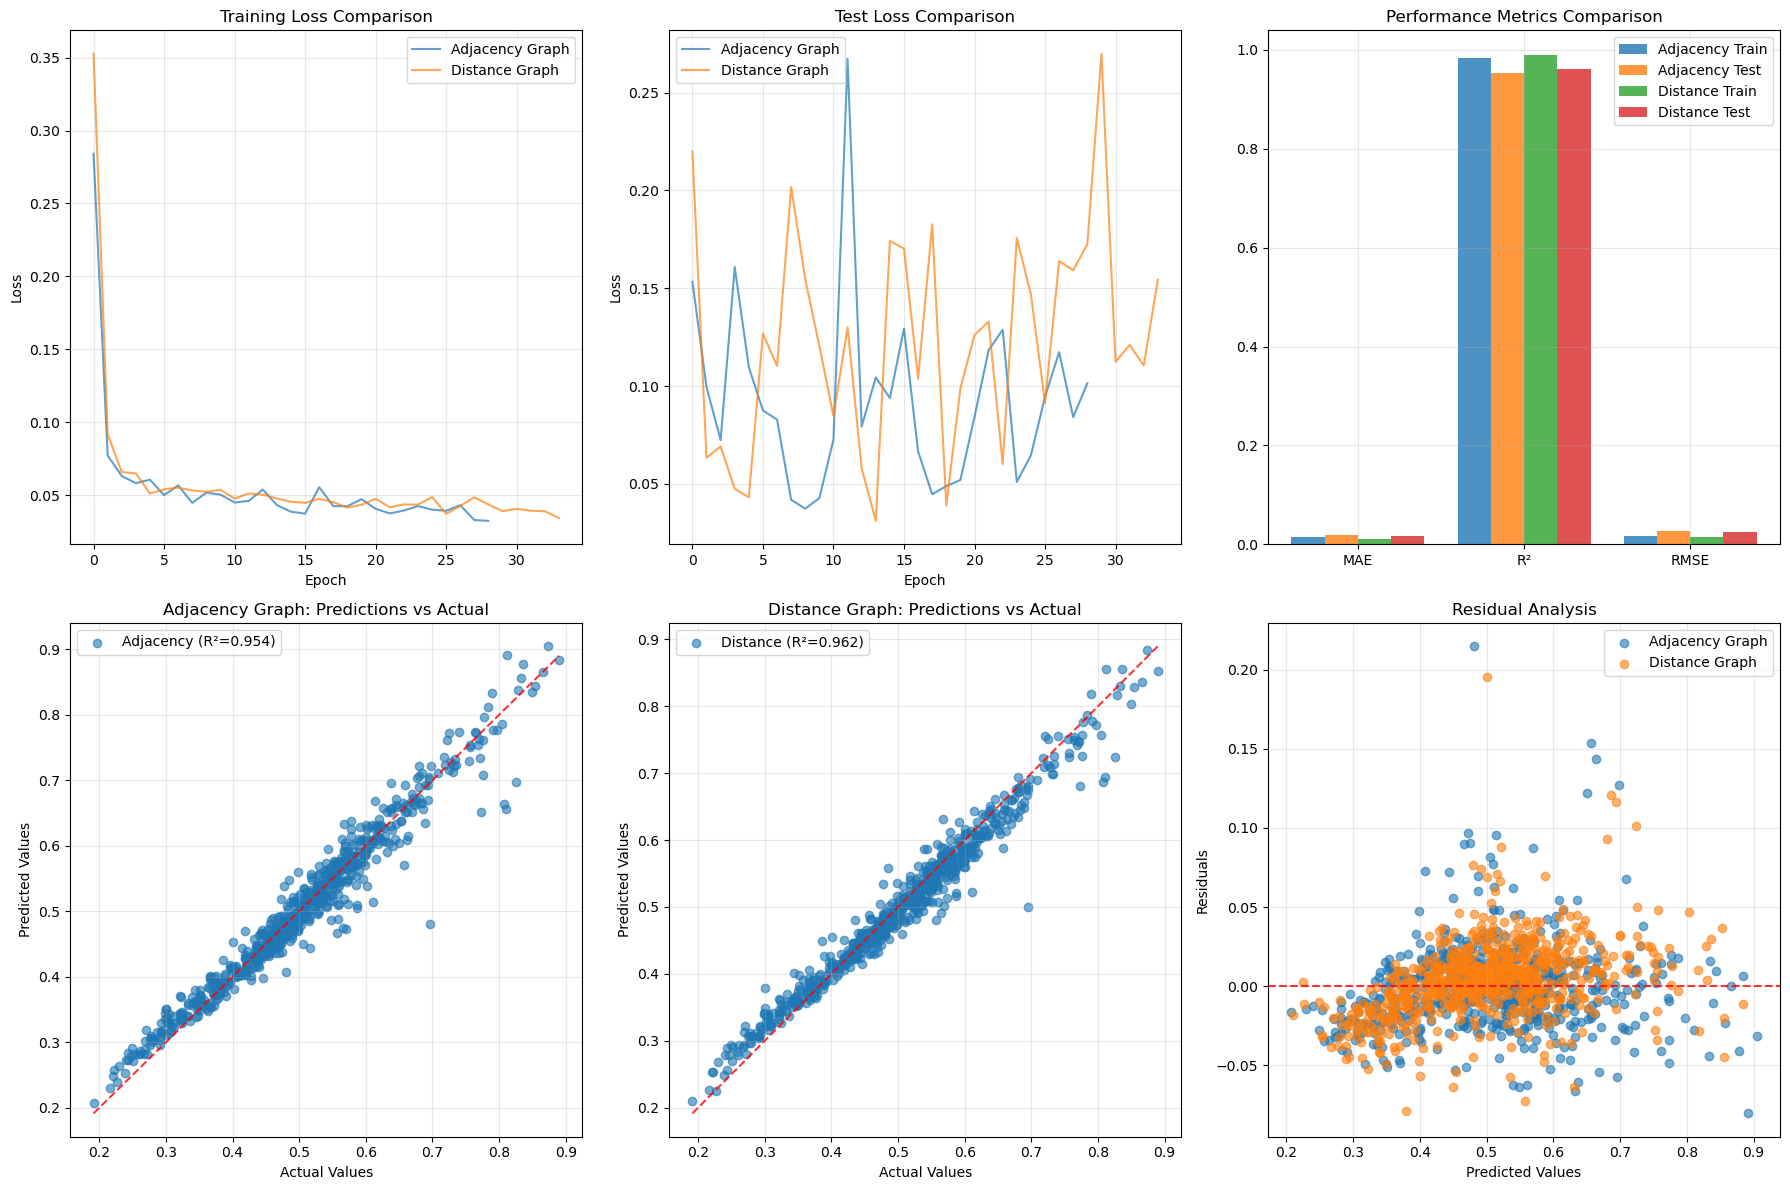


STGCN model training completed (flexible time window + complete features + infection rate derived features)
Feature composition:
  - Time series features: 27 features/day × 7 days = 189 time series features
    * Original wastewater features: 15
    * Historical infection rate feature: 1
    * Infection rate derived features: 11
  - Socio-economic features: 5 (static)
  - Total features: 194

Core strategies:
  ✓ Predict from day 8 of data, ensure full history window
  ✓ Strict 7-day time window, do not use prediction day data
  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic
  ✓ Include infection rate data for each of the past 7 days
  ✓ Include 11 derived features based on historical infection rates
  ✓ Include complete features: original + infection rate + derived + socio-economic
  ✓ Support both adjacency and distance graph structures

10. Save model results and predictions...
Adjacency graph model training epochs: 29
Distance graph model training epochs

In [4]:
##### STGCN version 4 - past 7 days infection rate features + infection rate derived features + socio-economic features

print("=== STGCN version 4 - past 7 days infection rate features + infection rate derived features + socio-economic features ===")

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load data
print("\n1. Load data...")
data = pd.read_csv('../data/processed/london_data_transformed.csv')
socio_data = pd.read_csv('../data/processed/cis_socio_economic_data.csv')

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['CIS20CD', 'date']).reset_index(drop=True)

print(f"Data shape: {data.shape}")
print(f"Time range: {data['date'].min()} to {data['date'].max()}")

# Get CIS regions
cis_regions = data['CIS20CD'].unique()
socio_cis = socio_data['CIS20CD'].unique()
common_cis = set(cis_regions) & set(socio_cis)

print(f"Number of CIS regions: {len(cis_regions)}")
print(f"Number of matching CIS regions: {len(common_cis)}")

# Original features (15 features)
original_features = [
    'sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
    'sample_ph_pre_ansis', 'control_gc_l_mean', 'raw_ansis_sars_repc_std',
    'grab_compo_boo', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
    'catchment_population_ons_mid_2019', 'catchment_area', 'catch_in_cis_prop',
    'catch_cis_population'
]

# Socio-economic features (5 features)
socio_features = ['IMD_Score', 'Population_Density', 'Elderly_Ratio', 'Overcrowding_Rate', 'Ethnic_Diversity_Index']

print(f"\nOriginal features ({len(original_features)} features):")
for i, feat in enumerate(original_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nSocio-economic features ({len(socio_features)} features):")
for i, feat in enumerate(socio_features, 1):
    print(f"  {i}. {feat}")

# 2. Build graph structure
print("\n2. Build graph structure...")

def load_cis_boundaries():
    """Load CIS boundary data"""
    shp_path = '../data/raw/Boundaries data/Covid_Infection_Survey_Dec_2020_UK_BUC_-6314666778913437735/CIS_DEC_2020_UK_BUC.shp'
    cis_geo = gpd.read_file(shp_path)
    return cis_geo

def create_adjacency_graph(cis_codes, cis_geo):
    """Create adjacency graph based on geographic adjacency"""
    cis_to_idx = {cis: idx for idx, cis in enumerate(cis_codes)}
    idx_to_cis = {idx: cis for cis, idx in cis_to_idx.items()}
    
    n = len(cis_codes)
    adj_matrix = np.zeros((n, n))
    
    adjacency_count = 0
    for i, cis1 in enumerate(cis_codes):
        if cis1 in cis_geo['CIS20CD'].values:
            geom1 = cis_geo[cis_geo['CIS20CD'] == cis1].geometry.iloc[0]
            
            for j, cis2 in enumerate(cis_codes):
                if i != j and cis2 in cis_geo['CIS20CD'].values:
                    geom2 = cis_geo[cis_geo['CIS20CD'] == cis2].geometry.iloc[0]
                    
                    if geom1.touches(geom2):
                        adj_matrix[i, j] = 1
                        adjacency_count += 1
    
    print(f"  Build adjacency graph...")
    print(f"    Found {adjacency_count} adjacency relationships")
    print(f"    Average number of neighbors per region: {adjacency_count / n:.2f}")
    
    return adj_matrix, cis_to_idx, idx_to_cis

def create_distance_graph(cis_codes, cis_geo, k_neighbors=5):
    """Create k-nearest neighbor graph based on distance"""
    n = len(cis_codes)
    centroids = []
    
    for cis in cis_codes:
        if cis in cis_geo['CIS20CD'].values:
            geom = cis_geo[cis_geo['CIS20CD'] == cis].geometry.iloc[0]
            centroid = geom.centroid
            centroids.append([centroid.x, centroid.y])
        else:
            centroids.append([0, 0])
    
    centroids = np.array(centroids)
    distances = cdist(centroids, centroids)
    
    adj_matrix = np.zeros((n, n))
    for i in range(n):
        nearest_indices = np.argsort(distances[i])[1:k_neighbors+1]
        adj_matrix[i, nearest_indices] = 1
        adj_matrix[nearest_indices, i] = 1
    
    print(f"  Build distance graph (k={k_neighbors})...")
    print(f"    Each region connects to {k_neighbors} nearest neighbors")
    
    return adj_matrix

# Load CIS boundaries and build graphs
cis_geo = load_cis_boundaries()
cis_codes = sorted(list(common_cis))
adjacency_adj, cis_to_idx, idx_to_cis = create_adjacency_graph(cis_codes, cis_geo)
distance_adj = create_distance_graph(cis_codes, cis_geo, k_neighbors=5)

print(f"Adjacency graph shape: {adjacency_adj.shape}")
print(f"Distance graph shape: {distance_adj.shape}")

# 3. Prepare flexible time window data (past 7 days infection rate + infection rate derived features + socio-economic features)
print("\n3. Prepare flexible time window data...")

def calculate_infection_rate_derived_features(infection_rates, availability_flags):
    """
    Calculate derived features based on past 7 days infection rates
    
    Parameters:
    - infection_rates: List of infection rates for past 7 days [day1, day2, ..., day7] (most recent to oldest)
    - availability_flags: List of data availability flags corresponding to the infection rates
    
    Returns:
    - Dictionary of derived features
    """
    # Only use infection rates with data
    valid_rates = [rate for rate, flag in zip(infection_rates, availability_flags) if flag == 1]
    
    derived_features = {}
    
    if len(valid_rates) == 0:
        # If there are no valid data, all derived features are 0
        derived_features = {
            'infection_rate_mean_7d': 0.0,
            'infection_rate_std_7d': 0.0,
            'infection_rate_trend_7d': 0.0,
            'infection_rate_max_7d': 0.0,
            'infection_rate_min_7d': 0.0,
            'infection_rate_range_7d': 0.0,
            'infection_rate_recent_3d_mean': 0.0,
            'infection_rate_change_1d': 0.0,
            'infection_rate_change_3d': 0.0,
            'infection_rate_volatility_7d': 0.0,
            'infection_rate_momentum_7d': 0.0
        }
    else:
        # Basic statistical features
        derived_features['infection_rate_mean_7d'] = np.mean(valid_rates)
        derived_features['infection_rate_std_7d'] = np.std(valid_rates) if len(valid_rates) > 1 else 0.0
        derived_features['infection_rate_max_7d'] = np.max(valid_rates)
        derived_features['infection_rate_min_7d'] = np.min(valid_rates)
        derived_features['infection_rate_range_7d'] = derived_features['infection_rate_max_7d'] - derived_features['infection_rate_min_7d']
        
        # Trend features (linear regression slope)
        if len(valid_rates) >= 2:
            x = np.arange(len(valid_rates))
            slope, _ = np.polyfit(x, valid_rates, 1)
            derived_features['infection_rate_trend_7d'] = slope
        else:
            derived_features['infection_rate_trend_7d'] = 0.0
        
        # Recent features (mean of past 3 days)
        recent_3d_rates = [rate for rate, flag in zip(infection_rates[:3], availability_flags[:3]) if flag == 1]
        derived_features['infection_rate_recent_3d_mean'] = np.mean(recent_3d_rates) if recent_3d_rates else 0.0
        
        # Change features
        if len(valid_rates) >= 2:
            # 1 day change (most recent day - previous day)
            if availability_flags[0] == 1 and availability_flags[1] == 1:
                derived_features['infection_rate_change_1d'] = infection_rates[0] - infection_rates[1]
            else:
                derived_features['infection_rate_change_1d'] = 0.0
            
            # 3 day change (mean of past 3 days - mean of previous 4-6 days)
            recent_3d = [rate for rate, flag in zip(infection_rates[:3], availability_flags[:3]) if flag == 1]
            earlier_3d = [rate for rate, flag in zip(infection_rates[3:6], availability_flags[3:6]) if flag == 1]
            
            if recent_3d and earlier_3d:
                derived_features['infection_rate_change_3d'] = np.mean(recent_3d) - np.mean(earlier_3d)
            else:
                derived_features['infection_rate_change_3d'] = 0.0
        else:
            derived_features['infection_rate_change_1d'] = 0.0
            derived_features['infection_rate_change_3d'] = 0.0
        
        # Volatility features (relative standard deviation)
        if derived_features['infection_rate_mean_7d'] > 0:
            derived_features['infection_rate_volatility_7d'] = derived_features['infection_rate_std_7d'] / derived_features['infection_rate_mean_7d']
        else:
            derived_features['infection_rate_volatility_7d'] = 0.0
        
        # Momentum features (weighted average, recent days have higher weight)
        if len(valid_rates) >= 3:
            weights = np.array([0.4, 0.3, 0.2, 0.1][:len(valid_rates)])
            weights = weights / weights.sum()
            derived_features['infection_rate_momentum_7d'] = np.average(valid_rates[:len(weights)], weights=weights)
        else:
            derived_features['infection_rate_momentum_7d'] = derived_features['infection_rate_mean_7d']
    
    return derived_features

def create_flexible_time_window_with_all_features_and_derived(data, socio_data, window_days=7):
    """
    Create flexible time window dataset, containing:
    - Original features (15 features) for the past window_days days
    - Infection rate data (1 feature) for the past window_days days
    - Derived features (11 features) based on past 7 days infection rates
    - Socio-economic features (5 features, static)
    - Target: Infection rate for the prediction day
    
    Core strategies:
    1. Prediction day must start from the 8th day of the first date in the data
    2. Each prediction day must have a complete 7-day history window available
    3. Use data if available, otherwise use 0
    4. Never use data from the prediction day or future dates!
    5. Derived features are completely based on historical infection rate data
    """
    
    sequences = []
    socio_features_list = []
    targets = []
    regions = []
    dates = []
    availability_stats = {
        'total_potential_pred_days': 0,  # Total days in the data
        'valid_pred_days': 0,            # Predict days satisfying the time window requirements
        'actual_pred_days': 0,           # Actual days used for prediction (with data)
        'total_samples': 0,              # Total number of samples
        'total_hist_days': 0,            # Total days in the history window
        'available_hist_days': 0         # Days with data in the history window
    }
    
    # Get the time range of the global data
    global_min_date = data['date'].min()
    global_max_date = data['date'].max()
    earliest_pred_date = global_min_date + pd.Timedelta(days=window_days)
    
    print(f"Time range analysis:")
    print(f"  Earliest date in data: {global_min_date.strftime('%Y-%m-%d')}")
    print(f"  Latest date in data: {global_max_date.strftime('%Y-%m-%d')}")
    print(f"  Earliest predictable date: {earliest_pred_date.strftime('%Y-%m-%d')} (Day {window_days+1})")
    
    # Group by CIS region
    for cis in cis_codes:
        cis_data = data[data['CIS20CD'] == cis].copy()
        cis_data = cis_data.sort_values('date').reset_index(drop=True)
        
        if len(cis_data) == 0:
            continue
            
        availability_stats['total_potential_pred_days'] += len(cis_data)
        
        # Get socio-economic features
        socio_row = socio_data[socio_data['CIS20CD'] == cis]
        if len(socio_row) == 0:
            continue
            
        socio_vec = socio_row[socio_features].values[0]
        
        # Create a mapping from date to data for quick lookup
        cis_date_data = {}
        for _, row in cis_data.iterrows():
            cis_date_data[row['date'].date()] = row
        
        # Get the time range of the CIS region
        cis_min_date = cis_data['date'].min()
        cis_max_date = cis_data['date'].max()
        cis_earliest_pred_date = cis_min_date + pd.Timedelta(days=window_days)
        
        # Iterate through all possible prediction dates for this CIS region
        # Start from the 8th day of the CIS region, to the last day
        current_date = cis_earliest_pred_date
        while current_date <= cis_max_date:
            availability_stats['valid_pred_days'] += 1
            
            # Check if the current date has data (can be used as a prediction day)
            if current_date.date() in cis_date_data:
                pred_target = cis_date_data[current_date.date()]['median_prob']
                availability_stats['actual_pred_days'] += 1
                
                # Build a strict 7-day history window (before the prediction day)
                sequence_features = []
                day_availability = []
                infection_rates_history = []
                
                for days_back in range(1, window_days + 1):  # 1-7 days ago
                    hist_date = (current_date - pd.Timedelta(days=days_back)).date()
                    
                    if hist_date in cis_date_data:
                        # Data available: use real value
                        hist_row = cis_date_data[hist_date]
                        # Original features (15 features) + infection rate (1 feature) = 16 features
                        day_features = np.concatenate([
                            hist_row[original_features].values,
                            [hist_row['median_prob']]
                        ])
                        day_availability.append(1)  # Mark as data available
                        infection_rates_history.append(hist_row['median_prob'])
                        availability_stats['available_hist_days'] += 1
                    else:
                        # No data: use 0
                        day_features = np.zeros(len(original_features) + 1)  # 16 zeros
                        day_availability.append(0)  # Mark as no data
                        infection_rates_history.append(0.0)
                    
                    sequence_features.append(day_features)
                    availability_stats['total_hist_days'] += 1
                
                # Calculate infection rate derived features (based on historical 7 days data)
                derived_features = calculate_infection_rate_derived_features(
                    infection_rates_history, day_availability
                )
                
                # Add derived features to each day's features
                derived_feature_values = list(derived_features.values())  # 11 derived features
                
                # Add derived features to each day
                enhanced_sequence_features = []
                for day_features in sequence_features:
                    enhanced_day_features = np.concatenate([
                        day_features,  # 16 features (15 original + 1 infection rate)
                        derived_feature_values  # 11 derived features
                    ])  # 27 features
                    enhanced_sequence_features.append(enhanced_day_features)
                
                enhanced_sequence_features = np.array(enhanced_sequence_features)  # shape: (window_days, 27)
                
                sequences.append(enhanced_sequence_features)
                socio_features_list.append(socio_vec)
                targets.append(pred_target)
                regions.append(cis)
                dates.append(current_date)
                availability_stats['total_samples'] += 1
            
            # Move to the next day
            current_date += pd.Timedelta(days=1)
    
    sequences = np.array(sequences)  # shape: (n_samples, window_days, 27)
    socio_features_array = np.array(socio_features_list)  # shape: (n_samples, 5)
    targets = np.array(targets)
    
    # Print detailed data availability statistics
    print(f"\n=== Data availability statistics ===")
    print(f"Prediction day statistics:")
    print(f"  Total days in data: {availability_stats['total_potential_pred_days']}")
    print(f"  Days satisfying the time window requirements: {availability_stats['valid_pred_days']}")
    print(f"  Actual days with data: {availability_stats['actual_pred_days']}")
    print(f"  Prediction day utilization: {availability_stats['actual_pred_days']/availability_stats['valid_pred_days']*100:.1f}%")
    
    print(f"\nHistory window statistics:")
    print(f"  Total history days: {availability_stats['total_hist_days']}")
    print(f"  Days with data: {availability_stats['available_hist_days']}")
    print(f"  History data coverage: {availability_stats['available_hist_days']/availability_stats['total_hist_days']*100:.1f}%")
    print(f"  Average number of valid history days per sample: {availability_stats['available_hist_days']/availability_stats['total_samples']:.1f}/7 days")
    
    print(f"\nSample statistics:")
    print(f"  Total samples: {availability_stats['total_samples']}")
    print(f"  Average number of samples per CIS region: {availability_stats['total_samples']/len(cis_codes):.1f}")
    
    # Print derived feature list
    sample_derived = calculate_infection_rate_derived_features([0.1]*7, [1]*7)
    print(f"\nInfection rate derived features ({len(sample_derived)} features):")
    for i, feature_name in enumerate(sample_derived.keys(), 1):
        print(f"  {i:2d}. {feature_name}")
    
    return sequences, socio_features_array, targets, regions, dates

# Create dataset
sequences, socio_features_array, targets, sample_regions, sample_dates = create_flexible_time_window_with_all_features_and_derived(
    data, socio_data, window_days=7
)

print(f"\n=== Dataset shape ===")
print(f"  Sequence features: {sequences.shape}")  # (n_samples, 7, 27) - 27 features (15 original + 1 infection rate + 11 derived) per day
print(f"  Socio-economic features: {socio_features_array.shape}")  # (n_samples, 5)
print(f"  Target: {targets.shape}")
print(f"  Total samples: {len(targets)}")

# Feature description
print(f"\n=== Feature composition ===")
print(f"Time series features (per sample):")
print(f"  - Day 1 ago: 15 original features + 1 infection rate + 11 derived features = 27")
print(f"  - Day 2 ago: 15 original features + 1 infection rate + 11 derived features = 27")
print(f"  - Day 3 ago: 15 original features + 1 infection rate + 11 derived features = 27")
print(f"  - Day 4 ago: 15 original features + 1 infection rate + 11 derived features = 27")
print(f"  - Day 5 ago: 15 original features + 1 infection rate + 11 derived features = 27")
print(f"  - Day 6 ago: 15 original features + 1 infection rate + 11 derived features = 27")
print(f"  - Day 7 ago: 15 original features + 1 infection rate + 11 derived features = 27")
print(f"  Total: 27 × 7 = 189 time series features")

print(f"\nSocio-economic features (static):")
for i, feat in enumerate(socio_features, 1):
    print(f"  - {feat}")
print(f"  Total: {len(socio_features)} socio-economic features")

print(f"\nTotal features: 189 + {len(socio_features)} = {189 + len(socio_features)}")

print(f"\n=== Derived feature description ===")
print(f"Infection rate derived features (based on past 7 days history data):")
print(f"  1. infection_rate_mean_7d: 7 day infection rate mean")
print(f"  2. infection_rate_std_7d: 7 day infection rate standard deviation")
print(f"  3. infection_rate_trend_7d: 7 day infection rate trend (linear regression slope)")
print(f"  4. infection_rate_max_7d: 7 day infection rate maximum")
print(f"  5. infection_rate_min_7d: 7 day infection rate minimum")
print(f"  6. infection_rate_range_7d: 7 day infection rate range")
print(f"  7. infection_rate_recent_3d_mean: 3 day infection rate mean")
print(f"  8. infection_rate_change_1d: 1 day change (today - yesterday)")
print(f"  9. infection_rate_change_3d: 3 day change (recent 3 day mean - 3 day mean)")
print(f"  10. infection_rate_volatility_7d: 7 day volatility (relative standard deviation)")
print(f"  11. infection_rate_momentum_7d: 7 day momentum (weighted average)")

print(f"\n=== Strategy validation ===")
print(f"✓ Prediction day selection: start from day {7+1} in data, ensure complete history window")
print(f"✓ History window: strict 7 day window (1-7 days before prediction day)")
print(f"✓ Missing data: use 0 for history window without data")
print(f"✓ Time boundary: never use data from prediction day or future dates")
print(f"✓ Feature complete: include original + infection rate + derived + socio-economic features")
print(f"✓ Derived features: completely based on historical 7 days infection rate data")

# Example to validate time logic
print(f"\n=== Time logic example ===")
if len(sample_dates) > 0:
    # Show time logic for the first 3 samples
    for i in range(min(3, len(sample_dates))):
        sample_pred_date = sample_dates[i]
        print(f"Sample {i}:")
        print(f"  Prediction day: {sample_pred_date.strftime('%Y-%m-%d')}")
        print(f"  History window: {(sample_pred_date - pd.Timedelta(days=7)).strftime('%Y-%m-%d')} to {(sample_pred_date - pd.Timedelta(days=1)).strftime('%Y-%m-%d')}")
        print(f"  Prediction target: {targets[i]:.4f}")
        print(f"  CIS region: {sample_regions[i]}")
        print()

# Validate no future data
print(f"=== Time safety validation ===")
sample_dates_array = np.array(sample_dates)
min_pred_date = sample_dates_array.min()
max_pred_date = sample_dates_array.max()
print(f"Prediction date range: {min_pred_date.strftime('%Y-%m-%d')} to {max_pred_date.strftime('%Y-%m-%d')}")
print(f"Earliest prediction day distance from data start: {(min_pred_date - data['date'].min()).days} days")
print(f"✓ Confirm: earliest prediction day at least on the {7+1}th day from data start")

# Time split
print("\n4. Time split...")
sample_dates_dt = pd.to_datetime(sample_dates)
sorted_dates = sorted(sample_dates_dt.unique())
split_idx = int(len(sorted_dates) * 0.7)
split_date = sorted_dates[split_idx]

train_mask = sample_dates_dt <= split_date
test_mask = sample_dates_dt > split_date

train_sequences = sequences[train_mask]
train_socio = socio_features_array[train_mask]
train_targets = targets[train_mask]
train_regions = [sample_regions[i] for i in range(len(sample_regions)) if train_mask[i]]

test_sequences = sequences[test_mask]
test_socio = socio_features_array[test_mask]
test_targets = targets[test_mask]
test_regions = [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]]

print(f"Training set: {len(train_targets)} samples")
print(f"Test set: {len(test_targets)} samples")
print(f"Split date: {split_date}")

# Feature standardization
print("\n5. Feature standardization...")
scaler_seq = StandardScaler()
scaler_socio = StandardScaler()
scaler_target = StandardScaler()

# Standardize sequence features (reshape to 2D for standardization)
n_train, n_days, n_features = train_sequences.shape
train_seq_2d = train_sequences.reshape(-1, n_features)
train_seq_scaled_2d = scaler_seq.fit_transform(train_seq_2d)
train_seq_scaled = train_seq_scaled_2d.reshape(n_train, n_days, n_features)

n_test = test_sequences.shape[0]
test_seq_2d = test_sequences.reshape(-1, n_features)
test_seq_scaled_2d = scaler_seq.transform(test_seq_2d)
test_seq_scaled = test_seq_scaled_2d.reshape(n_test, n_days, n_features)

# Standardize socio-economic features
train_socio_scaled = scaler_socio.fit_transform(train_socio)
test_socio_scaled = scaler_socio.transform(test_socio)

# Standardize target
train_targets_scaled = scaler_target.fit_transform(train_targets.reshape(-1, 1)).flatten()
test_targets_scaled = scaler_target.transform(test_targets.reshape(-1, 1)).flatten()

print("Feature standardization completed")

# STGCN model definition
print("\n6. Define STGCN model...")

class STGCNBlock(nn.Module):
    """STGCN basic block: temporal convolution + spatial graph convolution + temporal convolution"""
    def __init__(self, in_channels, out_channels, num_nodes, kernel_size=3):
        super(STGCNBlock, self).__init__()
        
        # Temporal convolution 1
        self.temporal_conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=(0, 1))
        
        # Spatial graph convolution
        self.spatial_conv = GCNConv(out_channels, out_channels)
        
        # Temporal convolution 2
        self.temporal_conv2 = nn.Conv2d(out_channels, out_channels, (1, kernel_size), padding=(0, 1))
        
        # Residual connection
        self.residual_conv = nn.Conv2d(in_channels, out_channels, (1, 1)) if in_channels != out_channels else None
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, edge_index, edge_weight=None):
        # x shape: (batch_size, num_nodes, timesteps, features)
        batch_size, num_nodes, timesteps, features = x.shape
        
        # Residual connection
        residual = x
        
        # Convert to (batch_size, features, num_nodes, timesteps) for temporal convolution
        x = x.permute(0, 3, 1, 2)
        
        # Temporal convolution 1
        x = self.temporal_conv1(x)
        x = self.relu(x)
        
        # Convert to (batch_size, num_nodes, timesteps, features)
        x = x.permute(0, 2, 3, 1)
        
        # Spatial graph convolution (for each time step)
        spatial_out = []
        for t in range(x.shape[2]):
            # x[:, :, t, :] shape: (batch_size, num_nodes, features)
            xt = x[:, :, t, :].contiguous().view(-1, x.shape[3])  # (batch_size * num_nodes, features)
            
            # Graph convolution
            xt = self.spatial_conv(xt, edge_index, edge_weight)  # (batch_size * num_nodes, features)
            xt = self.relu(xt)
            
            # Reshape back to (batch_size, num_nodes, features)
            xt = xt.view(batch_size, num_nodes, -1)
            spatial_out.append(xt)
        
        # Stack time dimension
        x = torch.stack(spatial_out, dim=2)  # (batch_size, num_nodes, timesteps, features)
        
        # Convert to (batch_size, features, num_nodes, timesteps) for temporal convolution 2
        x = x.permute(0, 3, 1, 2)  # (batch_size, features, num_nodes, timesteps)
        x = self.temporal_conv2(x)
        x = x.permute(0, 2, 3, 1)  # (batch_size, num_nodes, timesteps, features)
        
        # Residual connection
        if self.residual_conv is not None:
            residual = residual.permute(0, 3, 1, 2)
            residual = self.residual_conv(residual)
            residual = residual.permute(0, 2, 3, 1)
        
        x = x + residual
        x = self.relu(x)
        x = self.dropout(x)
        
        return x

class STGCN_WithInfectionRatesAndDerivedAndSocio(nn.Module):
    """STGCN model - time series features with infection rates and derived features + socio-economic features"""
    def __init__(self, num_nodes, num_time_features, num_timesteps, num_socio_features, 
                 hidden_channels=32, num_layers=2):
        super(STGCN_WithInfectionRatesAndDerivedAndSocio, self).__init__()
        
        self.num_nodes = num_nodes
        self.num_timesteps = num_timesteps
        
        # STGCN block processes time series features (with infection rates and derived features)
        self.stgcn_blocks = nn.ModuleList()
        
        # First layer
        self.stgcn_blocks.append(
            STGCNBlock(num_time_features, hidden_channels, num_nodes)
        )
        
        # Subsequent layers
        for _ in range(num_layers - 1):
            self.stgcn_blocks.append(
                STGCNBlock(hidden_channels, hidden_channels, num_nodes)
            )
        
        # Socio-economic features branch
        self.socio_branch = nn.Sequential(
            nn.Linear(num_socio_features, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels // 2, hidden_channels // 2)
        )
        
        # Output layer
        stgcn_output_size = hidden_channels * num_timesteps
        combined_size = stgcn_output_size + hidden_channels // 2
        
        self.output_layer = nn.Sequential(
            nn.Linear(combined_size, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, 1)
        )
        
    def forward(self, x, target_region_indices, socio_features, edge_index, edge_weight=None):
        """
        x: (batch_size, num_nodes, timesteps, time_features) - time series features
        target_region_indices: (batch_size,) - target region indices
        socio_features: (batch_size, socio_features) - socio-economic features
        """
        batch_size = x.shape[0]
        
        # STGCN processes time series features
        for stgcn_block in self.stgcn_blocks:
            x = stgcn_block(x, edge_index, edge_weight)
        
        # Extract target region features
        target_features = []
        for i, region_idx in enumerate(target_region_indices):
            target_features.append(x[i, region_idx, :, :])  # (timesteps, features)
        
        target_features = torch.stack(target_features)  # (batch_size, timesteps, features)
        
        # Flatten time series features
        stgcn_out = target_features.flatten(start_dim=1)  # (batch_size, timesteps * features)
        
        # Process socio-economic features
        socio_out = self.socio_branch(socio_features)  # (batch_size, hidden_channels // 2)
        
        # Combine features
        combined = torch.cat([stgcn_out, socio_out], dim=1)
        
        # Output prediction
        output = self.output_layer(combined)
        
        return output.squeeze()

# Prepare training data
print("\n7. Prepare training data...")

def adjacency_to_edge_index_weight(adj_matrix):
    """Convert adjacency matrix to edge_index and edge_weight"""
    rows, cols = np.where(adj_matrix > 0)
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    edge_weight = torch.tensor(adj_matrix[rows, cols], dtype=torch.float)
    return edge_index, edge_weight

# Convert graph data
adjacency_edge_index, adjacency_edge_weight = adjacency_to_edge_index_weight(adjacency_adj)
distance_edge_index, distance_edge_weight = adjacency_to_edge_index_weight(distance_adj)

adjacency_edge_index = adjacency_edge_index.to(device)
adjacency_edge_weight = adjacency_edge_weight.to(device)
distance_edge_index = distance_edge_index.to(device)
distance_edge_weight = distance_edge_weight.to(device)

# Convert to tensor
train_seq_tensor = torch.FloatTensor(train_seq_scaled).to(device)
train_socio_tensor = torch.FloatTensor(train_socio_scaled).to(device)
train_target_tensor = torch.FloatTensor(train_targets_scaled).to(device)

test_seq_tensor = torch.FloatTensor(test_seq_scaled).to(device)
test_socio_tensor = torch.FloatTensor(test_socio_scaled).to(device)
test_target_tensor = torch.FloatTensor(test_targets_scaled).to(device)

# Create target region indices
train_region_indices = torch.LongTensor([cis_to_idx[region] for region in train_regions]).to(device)
test_region_indices = torch.LongTensor([cis_to_idx[region] for region in test_regions]).to(device)

print(f"Training data shape:")
print(f"  Sequence: {train_seq_tensor.shape}")
print(f"  Socio-economic: {train_socio_tensor.shape}")
print(f"  Target: {train_target_tensor.shape}")
print(f"  Region indices: {train_region_indices.shape}")

# Check tensor dimensions
print(f"\nTensor dimensions details:")
print(f"  train_seq_tensor.shape: {train_seq_tensor.shape}")  # should be (n_samples, 7, 27)
print(f"  train_seq_tensor.ndim: {train_seq_tensor.ndim}")    # should be 3

# Model training
print("\n8. Model training...")

def train_stgcn_model(model_name, edge_index, edge_weight):
    """Train STGCN model"""
    print(f"\nTraining {model_name} model...")
    
    # Model parameters - fix dimension problem
    num_regions = len(cis_codes)
    
    # Fix: correctly get feature dimensions
    if train_seq_tensor.ndim == 3:  # (n_samples, timesteps, features)
        num_time_features = train_seq_tensor.shape[2]  # 27 features (15 original + 1 infection rate + 11 derived)
        num_timesteps = train_seq_tensor.shape[1]  # 7 days
    else:
        print(f"Error: training sequence tensor dimension is incorrect! Dimension: {train_seq_tensor.shape}")
        return None
        
    num_socio_features = train_socio_tensor.shape[1]  # 5 socio-economic features
    
    print(f"Model parameters:")
    print(f"  Number of regions: {num_regions}")
    print(f"  Number of time features: {num_time_features}")
    print(f"  Number of time steps: {num_timesteps}")
    print(f"  Number of socio-economic features: {num_socio_features}")
    
    model = STGCN_WithInfectionRatesAndDerivedAndSocio(
        num_nodes=num_regions,
        num_time_features=num_time_features,
        num_timesteps=num_timesteps,
        num_socio_features=num_socio_features,
        hidden_channels=32,
        num_layers=2
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    # Training loop
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience = 20
    early_stop_counter = 0
    
    # Data loader (batch processing)
    batch_size = 32
    num_train_batches = (len(train_seq_tensor) + batch_size - 1) // batch_size
    
    for epoch in range(200):
        # Training
        model.train()
        epoch_train_loss = 0
        
        for batch_idx in range(num_train_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(train_seq_tensor))
            
            # Batch data
            batch_seq = train_seq_tensor[start_idx:end_idx]  # (batch_size, 7, 27)
            batch_socio = train_socio_tensor[start_idx:end_idx]
            batch_target = train_target_tensor[start_idx:end_idx]
            batch_region_idx = train_region_indices[start_idx:end_idx]
            
            # Expand sequence data to (batch_size, num_nodes, timesteps, features)
            # Each sample needs to be copied to all nodes
            batch_size_actual = batch_seq.shape[0]
            batch_seq_expanded = batch_seq.unsqueeze(1).expand(-1, num_regions, -1, -1)  # (batch_size, num_nodes, 7, 27)
            
            # Forward propagation
            batch_pred = model(batch_seq_expanded, batch_region_idx, batch_socio, edge_index, edge_weight)
            batch_loss = criterion(batch_pred, batch_target)
            
            # Backward propagation
            optimizer.zero_grad()
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_loss += batch_loss.item()
        
        avg_train_loss = epoch_train_loss / num_train_batches
        
        # Validation
        model.eval()
        with torch.no_grad():
            test_seq_expanded = test_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
            test_pred = model(test_seq_expanded, test_region_indices, test_socio_tensor, edge_index, edge_weight)
            test_loss = criterion(test_pred, test_target_tensor)
        
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss.item())
        
        scheduler.step(test_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            early_stop_counter = 0
            # Save best model
            torch.save(model.state_dict(), f'../models/stgcn_version_4_{model_name.lower()}_with_all_features_derived.pth')
        else:
            early_stop_counter += 1
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d}: Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, LR: {current_lr:.6f}")
        
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(f'../models/stgcn_version_4_{model_name.lower()}_with_all_features_derived.pth'))
    model.eval()
    
    with torch.no_grad():
        # Train set prediction
        train_seq_expanded = train_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
        train_pred = model(train_seq_expanded, train_region_indices, train_socio_tensor, edge_index, edge_weight)
        
        # Test set prediction
        test_seq_expanded = test_seq_tensor.unsqueeze(1).expand(-1, num_regions, -1, -1)
        test_pred = model(test_seq_expanded, test_region_indices, test_socio_tensor, edge_index, edge_weight)
        
        # Inverse transform prediction results
        train_pred_orig = scaler_target.inverse_transform(train_pred.cpu().numpy().reshape(-1, 1)).flatten()
        test_pred_orig = scaler_target.inverse_transform(test_pred.cpu().numpy().reshape(-1, 1)).flatten()
        
        # Calculate metrics
        train_mae = mean_absolute_error(train_targets, train_pred_orig)
        train_r2 = r2_score(train_targets, train_pred_orig)
        train_rmse = np.sqrt(mean_squared_error(train_targets, train_pred_orig))
        
        test_mae = mean_absolute_error(test_targets, test_pred_orig)
        test_r2 = r2_score(test_targets, test_pred_orig)
        test_rmse = np.sqrt(mean_squared_error(test_targets, test_pred_orig))
    
    print(f"\n{model_name} final results:")
    print(f"Train set - MAE: {train_mae:.4f}, R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
    print(f"Test set - MAE: {test_mae:.4f}, R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
    
    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_metrics': {'mae': train_mae, 'r2': train_r2, 'rmse': train_rmse},
        'test_metrics': {'mae': test_mae, 'r2': test_r2, 'rmse': test_rmse},
        'train_pred': train_pred_orig,
        'test_pred': test_pred_orig
    }

# Train two graph models
adjacency_results = train_stgcn_model("Adjacency", adjacency_edge_index, adjacency_edge_weight)
distance_results = train_stgcn_model("Distance", distance_edge_index, distance_edge_weight)

# Result visualization
print("\n9. Result visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training loss comparison
axes[0, 0].plot(adjacency_results['train_losses'], label='Adjacency Graph', alpha=0.7)
axes[0, 0].plot(distance_results['train_losses'], label='Distance Graph', alpha=0.7)
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test loss comparison
axes[0, 1].plot(adjacency_results['test_losses'], label='Adjacency Graph', alpha=0.7)
axes[0, 1].plot(distance_results['test_losses'], label='Distance Graph', alpha=0.7)
axes[0, 1].set_title('Test Loss Comparison')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Performance metrics comparison
metrics = ['MAE', 'R²', 'RMSE']
adjacency_train_vals = [adjacency_results['train_metrics']['mae'], 
                       adjacency_results['train_metrics']['r2'], 
                       adjacency_results['train_metrics']['rmse']]
adjacency_test_vals = [adjacency_results['test_metrics']['mae'], 
                      adjacency_results['test_metrics']['r2'], 
                      adjacency_results['test_metrics']['rmse']]
distance_train_vals = [distance_results['train_metrics']['mae'], 
                      distance_results['train_metrics']['r2'], 
                      distance_results['train_metrics']['rmse']]
distance_test_vals = [distance_results['test_metrics']['mae'], 
                     distance_results['test_metrics']['r2'], 
                     distance_results['test_metrics']['rmse']]

x = np.arange(len(metrics))
width = 0.2

axes[0, 2].bar(x - 1.5*width, adjacency_train_vals, width, label='Adjacency Train', alpha=0.8)
axes[0, 2].bar(x - 0.5*width, adjacency_test_vals, width, label='Adjacency Test', alpha=0.8)
axes[0, 2].bar(x + 0.5*width, distance_train_vals, width, label='Distance Train', alpha=0.8)
axes[0, 2].bar(x + 1.5*width, distance_test_vals, width, label='Distance Test', alpha=0.8)
axes[0, 2].set_title('Performance Metrics Comparison')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(metrics)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Predictions vs actual values scatter plot
axes[1, 0].scatter(test_targets, adjacency_results['test_pred'], alpha=0.6, label=f"Adjacency (R²={adjacency_results['test_metrics']['r2']:.3f})")
axes[1, 0].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 0].set_title('Adjacency Graph: Predictions vs Actual')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(test_targets, distance_results['test_pred'], alpha=0.6, label=f"Distance (R²={distance_results['test_metrics']['r2']:.3f})")
axes[1, 1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', alpha=0.8)
axes[1, 1].set_title('Distance Graph: Predictions vs Actual')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Residual analysis
adjacency_residuals = test_targets - adjacency_results['test_pred']
distance_residuals = test_targets - distance_results['test_pred']

axes[1, 2].scatter(adjacency_results['test_pred'], adjacency_residuals, alpha=0.6, label='Adjacency Graph')
axes[1, 2].scatter(distance_results['test_pred'], distance_residuals, alpha=0.6, label='Distance Graph')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_title('Residual Analysis')
axes[1, 2].set_xlabel('Predicted Values')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/stgcn_version_4_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("STGCN model training completed (flexible time window + complete features + infection rate derived features)")
print("="*80)
print(f"Feature composition:")
print(f"  - Time series features: 27 features/day × 7 days = 189 time series features")
print(f"    * Original wastewater features: {len(original_features)}")
print(f"    * Historical infection rate feature: 1")
print(f"    * Infection rate derived features: 11")
print(f"  - Socio-economic features: {len(socio_features)} (static)")
print(f"  - Total features: 194")
print(f"\nCore strategies:")
print(f"  ✓ Predict from day 8 of data, ensure full history window")
print(f"  ✓ Strict 7-day time window, do not use prediction day data")
print(f"  ✓ Flexible handling of missing data, use 0 to fill to maintain time logic")
print(f"  ✓ Include infection rate data for each of the past 7 days")
print(f"  ✓ Include 11 derived features based on historical infection rates")
print(f"  ✓ Include complete features: original + infection rate + derived + socio-economic")
print(f"  ✓ Support both adjacency and distance graph structures")
print("="*80)

# Save model results and predictions
print("\n10. Save model results and predictions...")

# Save performance metrics summary
metrics_summary = pd.DataFrame({
    'model_type': ['STGCN_Adjacency_AllFeatures_Derived', 'STGCN_Distance_AllFeatures_Derived'],
    'train_mae': [adjacency_results['train_metrics']['mae'], distance_results['train_metrics']['mae']],
    'train_r2': [adjacency_results['train_metrics']['r2'], distance_results['train_metrics']['r2']],
    'train_rmse': [adjacency_results['train_metrics']['rmse'], distance_results['train_metrics']['rmse']],
    'test_mae': [adjacency_results['test_metrics']['mae'], distance_results['test_metrics']['mae']],
    'test_r2': [adjacency_results['test_metrics']['r2'], distance_results['test_metrics']['r2']],
    'test_rmse': [adjacency_results['test_metrics']['rmse'], distance_results['test_metrics']['rmse']],
    'feature_count': [194, 194],  # 189 time series features + 5 socio-economic features
    'sample_count': [len(test_targets), len(test_targets)]
})
metrics_summary.to_csv('../results/stgcn_version_4_all_features_derived_metrics_summary.csv', index=False)

# Save predictions - adjacency graph model
adjacency_predictions = pd.DataFrame({
    'actual': test_targets,
    'predicted': adjacency_results['test_pred'],
    'residual': test_targets - adjacency_results['test_pred'],
    'date': [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]],
    'cis_code': [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]],
    'model_type': 'STGCN_Adjacency_AllFeatures_Derived'
})
adjacency_predictions.to_csv('../results/stgcn_version_4_adjacency_all_features_derived_predictions.csv', index=False)

# Save predictions - distance graph model
distance_predictions = pd.DataFrame({
    'actual': test_targets,
    'predicted': distance_results['test_pred'],
    'residual': test_targets - distance_results['test_pred'],
    'date': [sample_dates[i] for i in range(len(sample_dates)) if test_mask[i]],
    'cis_code': [sample_regions[i] for i in range(len(sample_regions)) if test_mask[i]],
    'model_type': 'STGCN_Distance_AllFeatures_Derived'
})
distance_predictions.to_csv('../results/stgcn_version_4_distance_all_features_derived_predictions.csv', index=False)

# Save training history - fix length inconsistency problem
print(f"Adjacency graph model training epochs: {len(adjacency_results['train_losses'])}")
print(f"Distance graph model training epochs: {len(distance_results['train_losses'])}")

# Get the shortest training history length
min_epochs = min(len(adjacency_results['train_losses']), len(distance_results['train_losses']))
print(f"Save the first {min_epochs} epochs of training history")

training_history = pd.DataFrame({
    'epoch': range(min_epochs),
    'adjacency_train_loss': adjacency_results['train_losses'][:min_epochs],
    'adjacency_test_loss': adjacency_results['test_losses'][:min_epochs],
    'distance_train_loss': distance_results['train_losses'][:min_epochs],
    'distance_test_loss': distance_results['test_losses'][:min_epochs]
})
training_history.to_csv('../results/stgcn_version_4_all_features_derived_training_history.csv', index=False)

# If you need to save the complete training history, you can save it separately
adjacency_history = pd.DataFrame({
    'epoch': range(len(adjacency_results['train_losses'])),
    'train_loss': adjacency_results['train_losses'],
    'test_loss': adjacency_results['test_losses']
})
adjacency_history.to_csv('../results/stgcn_version_4_adjacency_all_features_derived_full_training_history.csv', index=False)

distance_history = pd.DataFrame({
    'epoch': range(len(distance_results['train_losses'])),
    'train_loss': distance_results['train_losses'],
    'test_loss': distance_results['test_losses']
})
distance_history.to_csv('../results/stgcn_version_4_distance_all_features_derived_full_training_history.csv', index=False)

print("STGCN complete features derived model results saved:")
print("  - Performance metrics: ../results/stgcn_version_4_all_features_derived_metrics_summary.csv")
print("  - Adjacency graph predictions: ../results/stgcn_version_4_adjacency_all_features_derived_predictions.csv")  
print("  - Distance graph predictions: ../results/stgcn_version_4_distance_all_features_derived_predictions.csv")
print("  - Merged training history: ../results/stgcn_version_4_all_features_derived_training_history.csv")
print("  - Adjacency graph full training history: ../results/stgcn_version_4_adjacency_all_features_derived_full_training_history.csv")
print("  - Distance graph full training history: ../results/stgcn_version_4_distance_all_features_derived_full_training_history.csv")